https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import chain
sns.set_style('whitegrid')
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
import cesium.featurize as featurize
from gatspy.periodic import LombScargleMultiband, LombScargleMultibandFast
import pdb

In [2]:
train_series = pd.read_csv('../input/training_set.csv')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')

In [3]:
groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

In [4]:
def fit_multiband_freq(tup):
    idx, group = tup
    t, f, e, b = group['mjd'], group['flux'], group['flux_err'], group['passband']
    model = LombScargleMultiband(fit_period=True)
    model.optimizer.period_range = (0.1, int((group['mjd'].max() - group['mjd'].min()) / 2))
    model.fit(t, f, e, b)
    return model

In [5]:
def get_freq_features(N, subsetting_pos=None):
    if subsetting_pos is None:
        subset_times_list = times_list
        subset_flux_list = flux_list
    else:
        subset_times_list = [v for i, v in enumerate(times_list) 
                             if i in set(subsetting_pos)]
        subset_flux_list = [v for i, v in enumerate(flux_list) 
                            if i in set(subsetting_pos)]
    feats = featurize.featurize_time_series(times=subset_times_list[:N],
                                            values=subset_flux_list[:N],
                                            features_to_use=['skew',
                                                            'percent_beyond_1_std',
                                                            'percent_difference_flux_percentile'
                                                            ],
                                            scheduler=None)
    subset = train_series[train_series['object_id'].isin(
        train_metadata['object_id'].iloc[subsetting_pos].iloc[:N])]
    models = list(map(fit_multiband_freq, subset.groupby('object_id')))
    feats['object_pos'] = subsetting_pos[:N]
    feats['freq1_freq'] = [model.best_period for model in models]
    return feats, models

In [6]:
unique_classes = train_metadata['target'].unique()
unique_classes

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

In [7]:
def get_class_feats(label, N=10):
    class_pos = train_metadata[train_metadata['target'] == label].index
    class_feats, class_models = get_freq_features(N, class_pos)
    return class_feats, class_models

In [8]:
def plot_phase_curves(feats, models, use_median_freq=False, hide_undetected=True, N=10):
    for i in range(N):
        freq = feats.loc[i, 'freq1_freq'].median()
        freq_min = feats.loc[i, 'freq1_freq'].min()
        freq_std = feats.loc[i, 'freq1_freq'].std()
        skew = feats.loc[i, 'skew'].mean()
        object_pos = int(feats.loc[i, 'object_pos'][0])
        f, ax = plt.subplots(1, 2, figsize=(14, 4))
        sample = train_series[train_series['object_id'] ==
                              train_metadata['object_id'].iloc[object_pos]].copy()
        colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
        score = models[i].score(models[i].best_period)
        
        ax[0].scatter(x=sample['mjd'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[0].vlines(sample['mjd'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        
        sample['phase'] = (sample['mjd'] / models[i].best_period) % 1
        ax[1].scatter(x=sample['phase'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[1].vlines(sample['phase'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        x_range = np.linspace(sample['mjd'].min(), sample['mjd'].max(), 1000)
        for band in range(6):
            y = models[i].predict(x_range, band)
            xs = (x_range / models[i].best_period) % 1
            ords = np.argsort(xs)
            ax[1].plot(xs[ords], y[ords], c=colors[band], alpha=0.4)
        
        title = ax[0].get_title()
        ax[0].set_title('time')
        ax[1].set_title('phase')
        f.suptitle(title + f'object: {sample["object_id"].iloc[0]}, '
                   f'class: {train_metadata["target"].iloc[object_pos]}\n'
                   f'period: {models[i].best_period: .4}, '
                   f'period score: {score: .4}, '
                   f'mean skew: {skew:.4}', y=1.1)
        plt.show()

In [9]:
warnings.simplefilter('ignore', UserWarning)

In [10]:
%%capture capt
feats, models = get_class_feats(92)

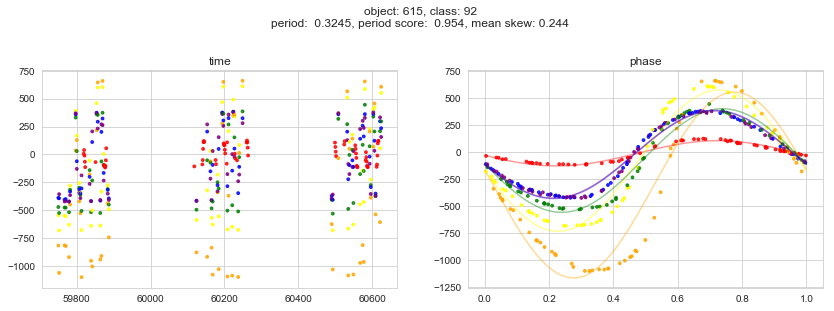

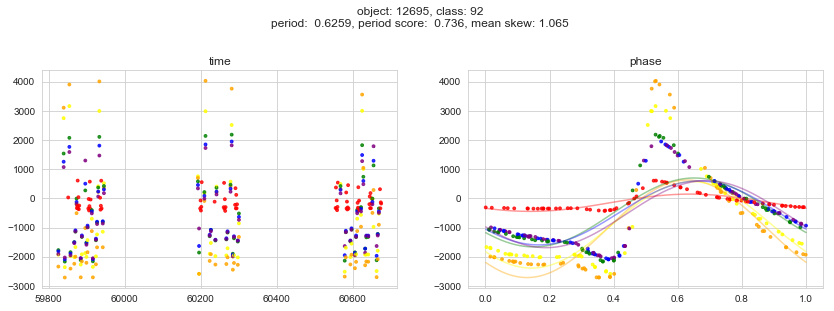

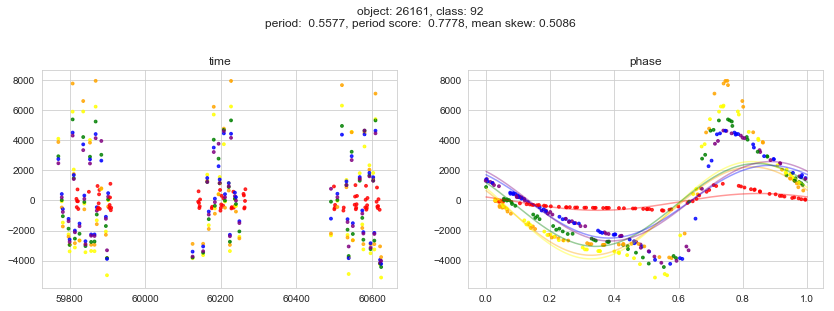

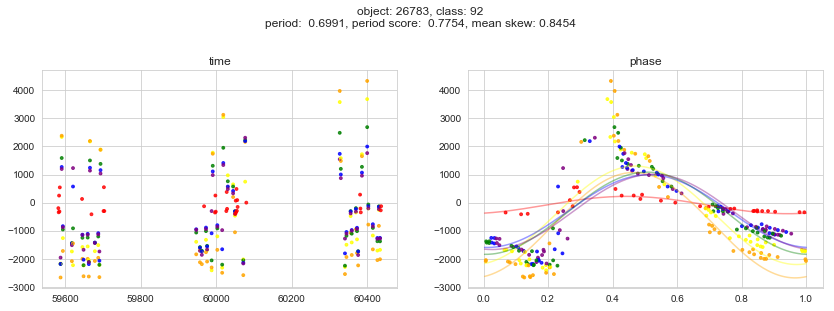

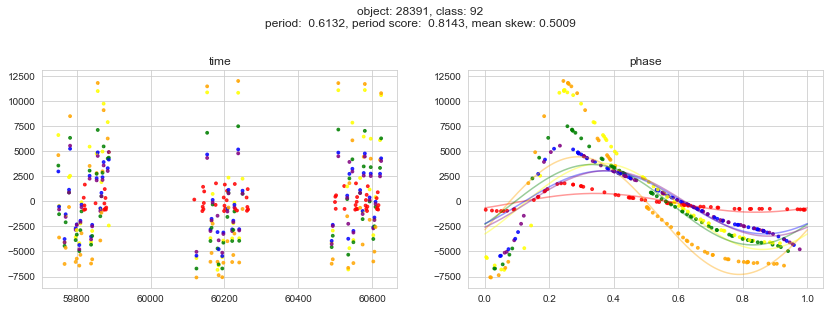

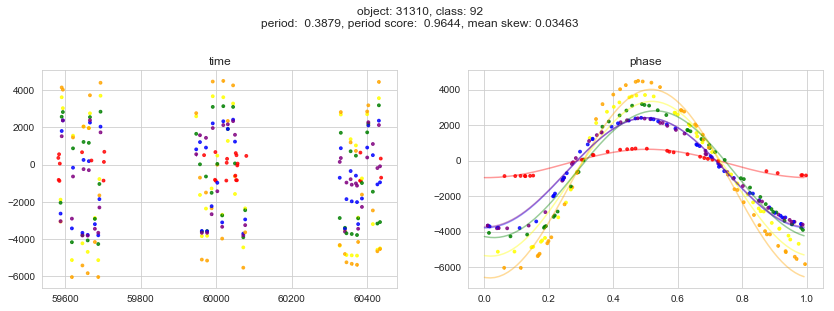

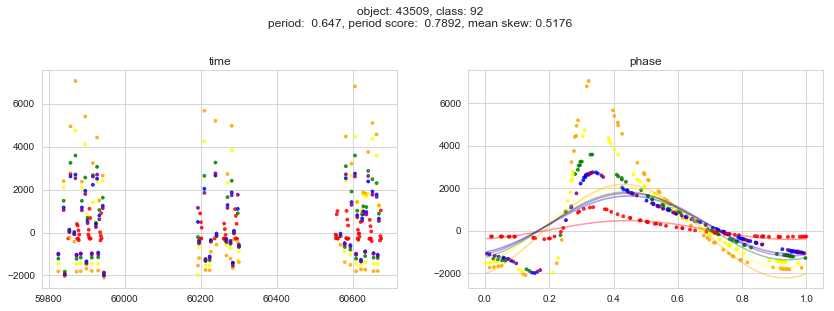

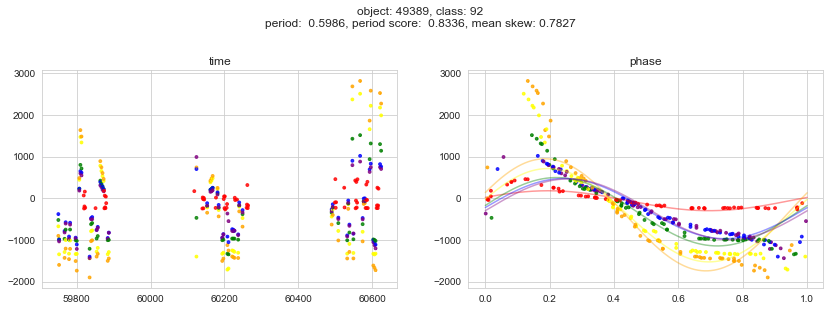

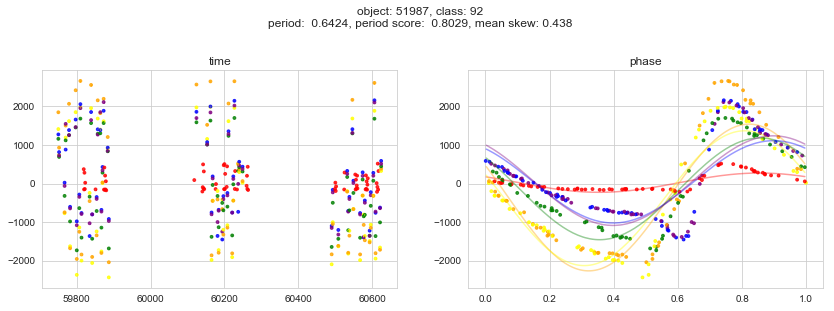

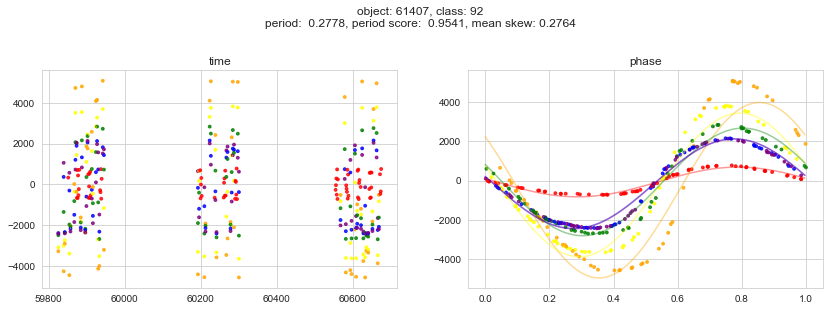

In [11]:
plot_phase_curves(feats, models)

In [12]:
%%capture capt
feats, models = get_class_feats(88)

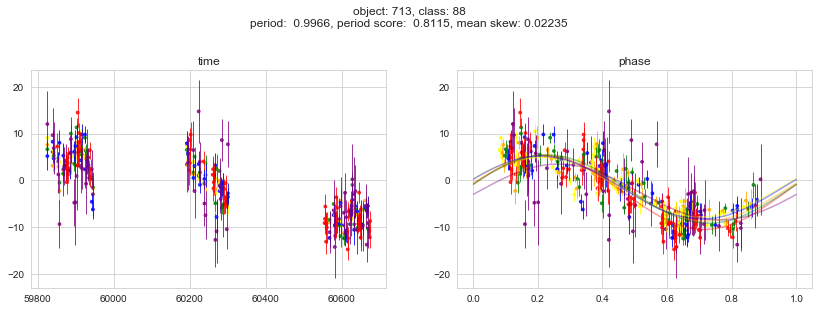

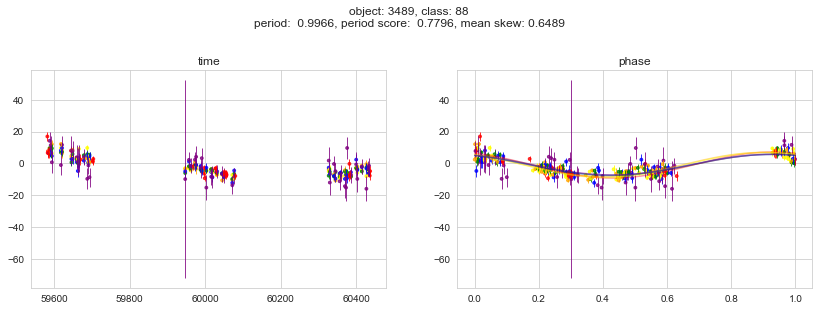

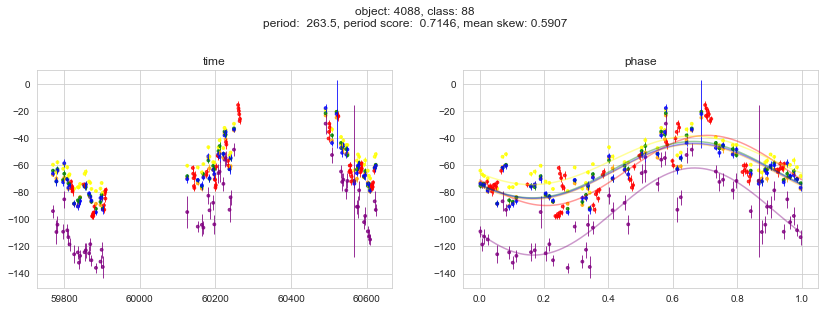

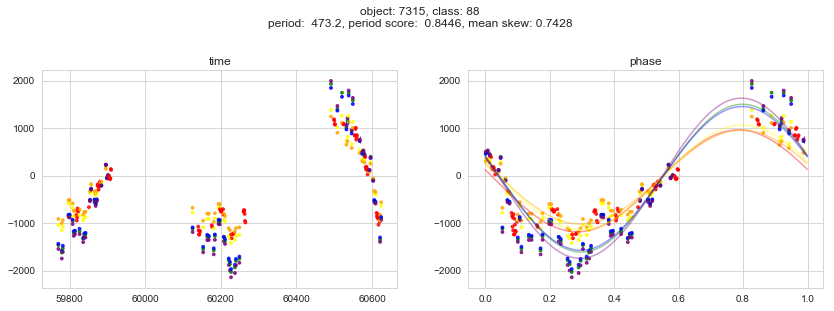

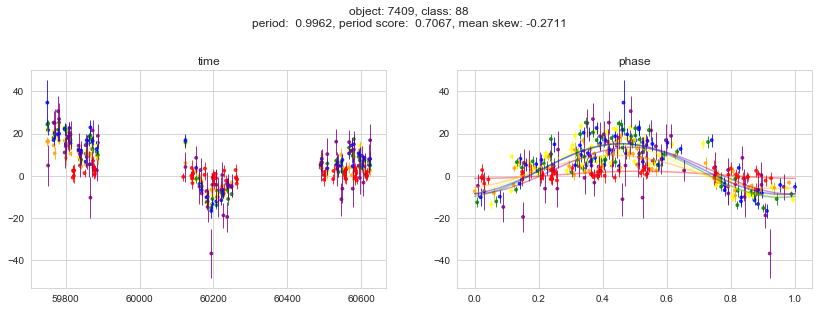

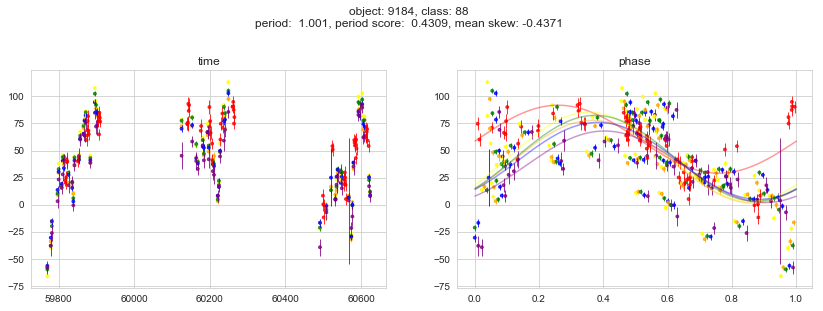

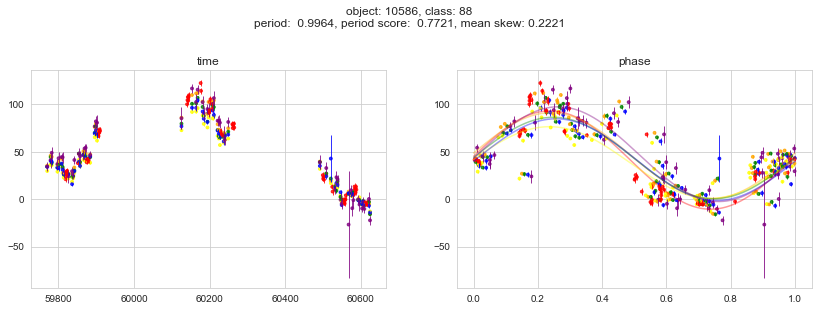

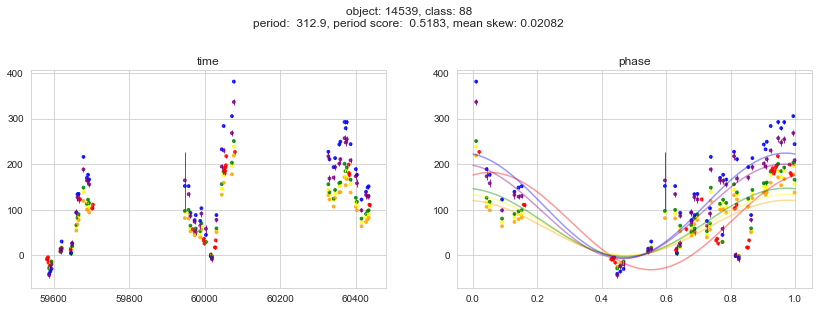

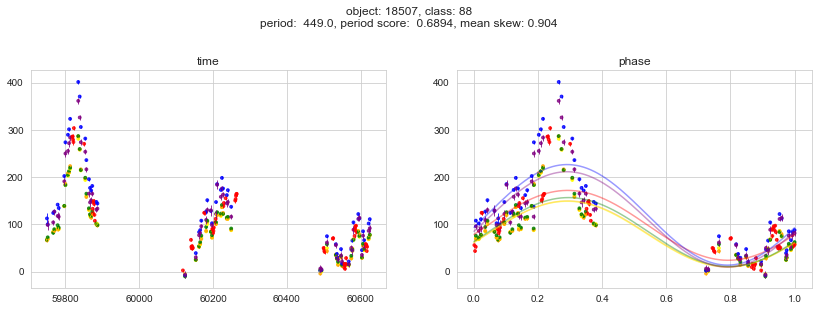

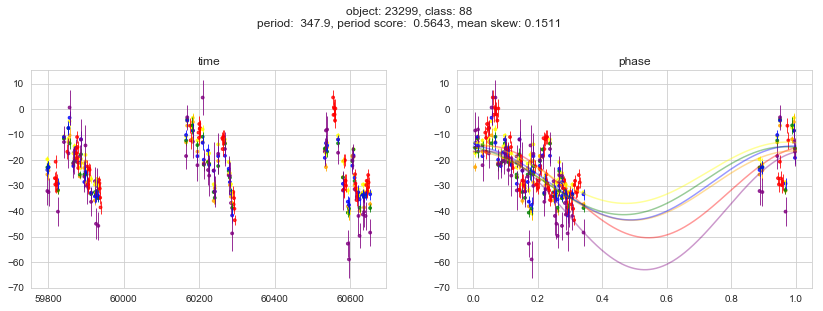

In [13]:
plot_phase_curves(feats, models)

In [14]:
%%capture capt
feats, models = get_class_feats(42)

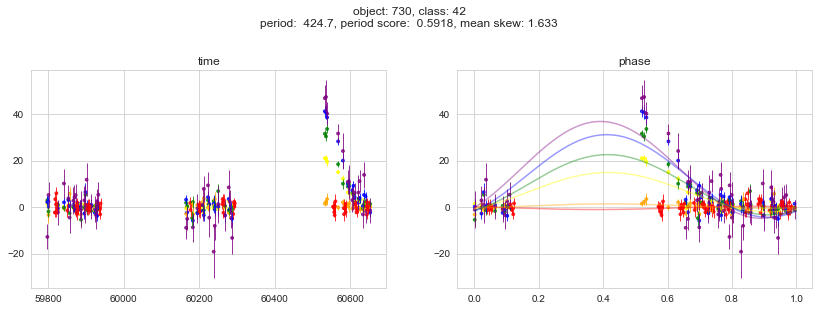

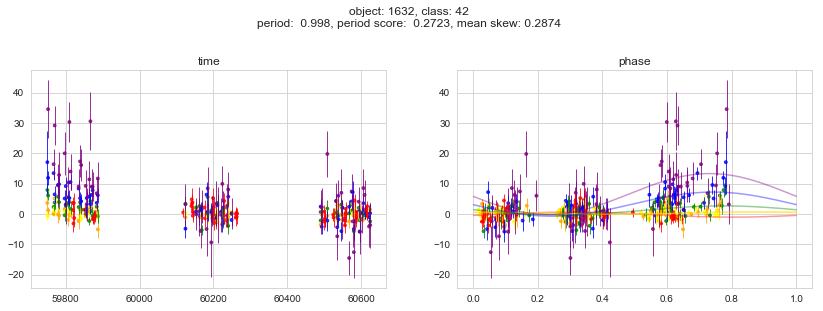

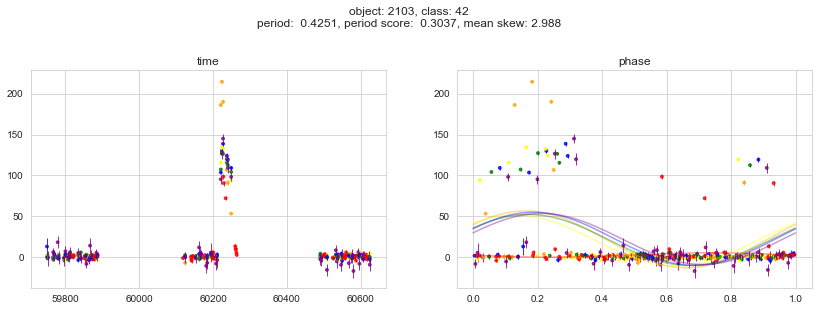

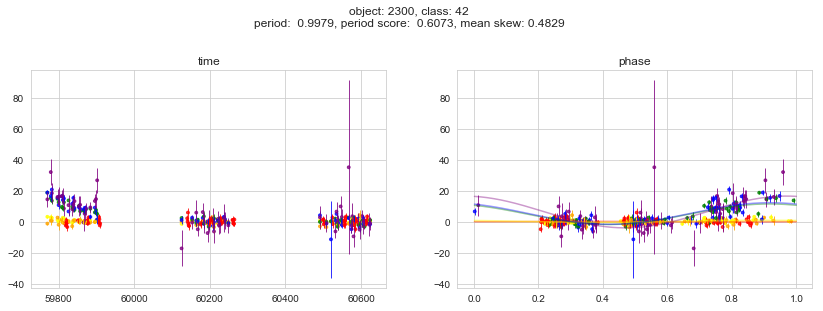

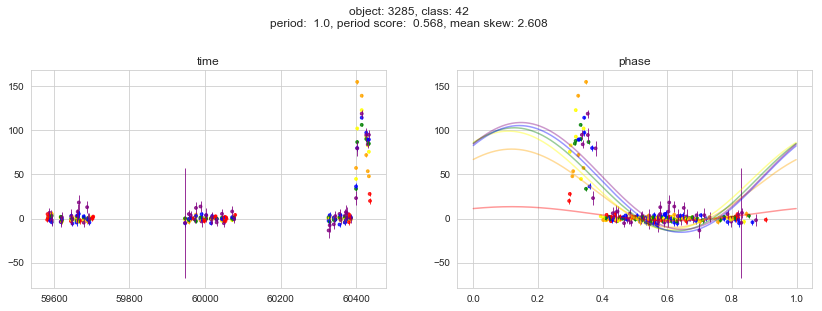

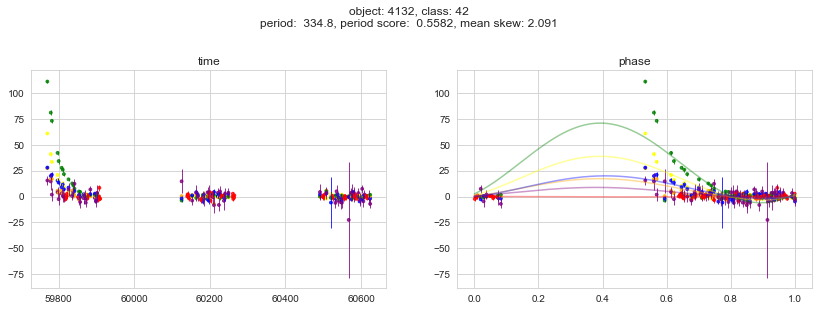

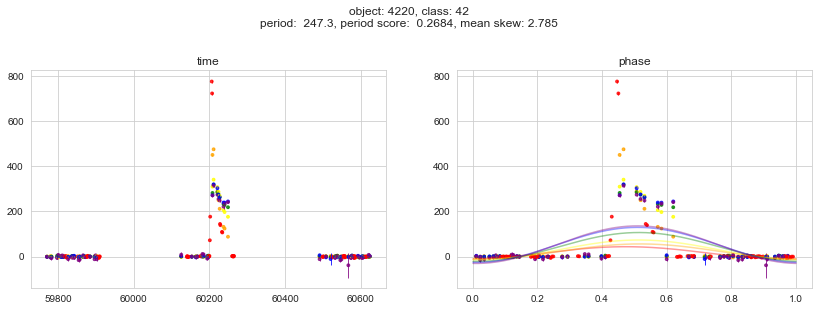

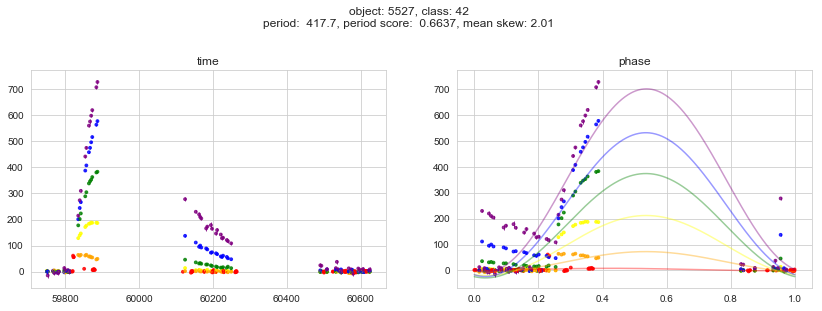

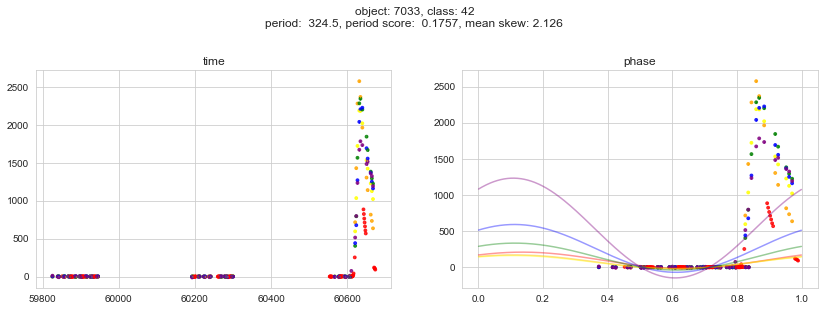

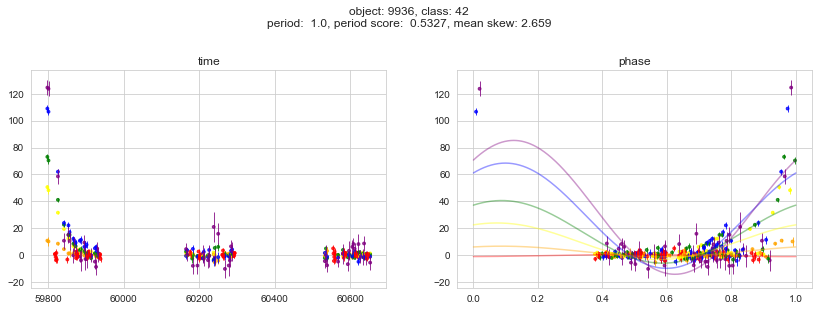

In [15]:
plot_phase_curves(feats, models)

In [16]:
%%capture capt
feats, models = get_class_feats(90)

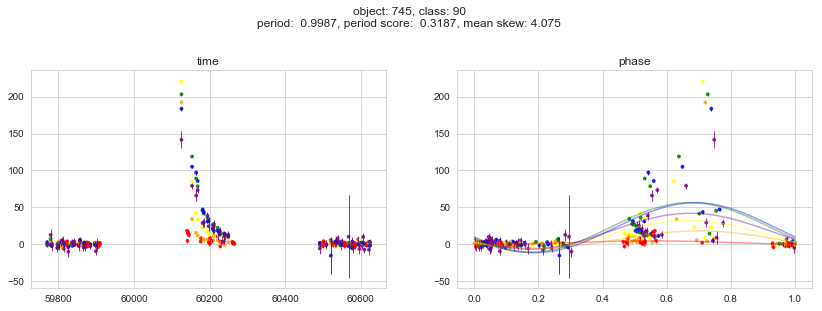

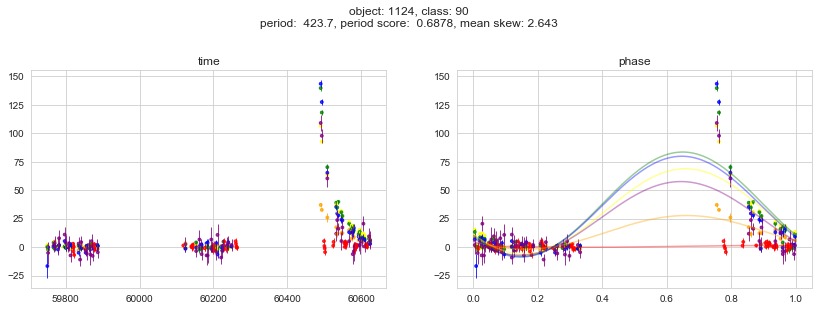

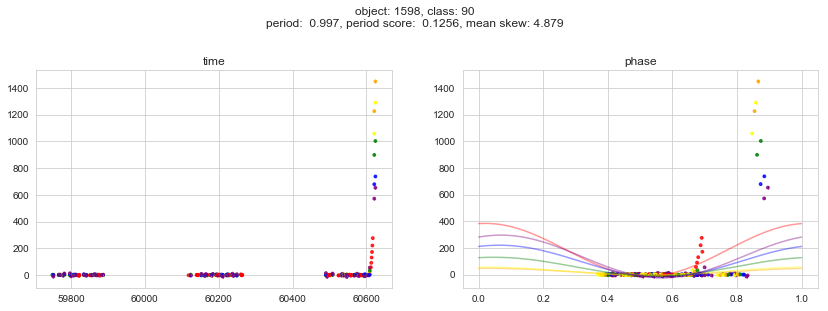

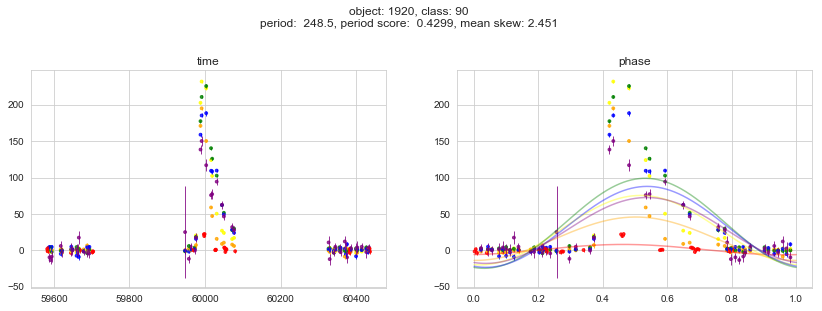

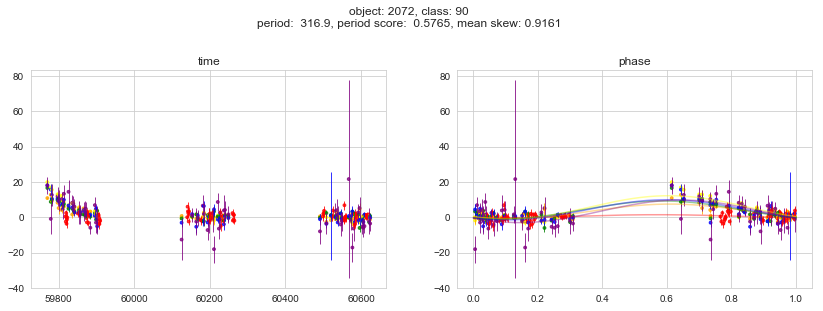

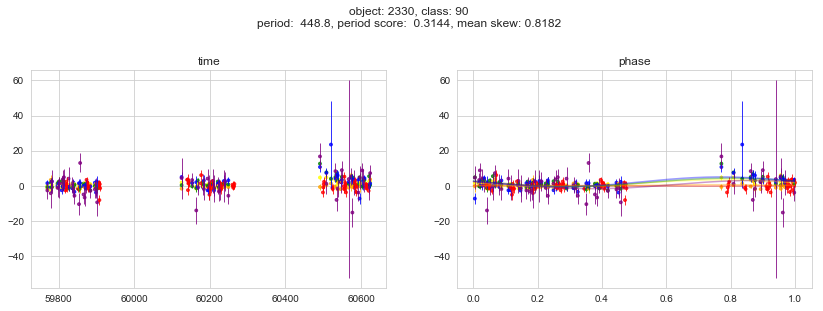

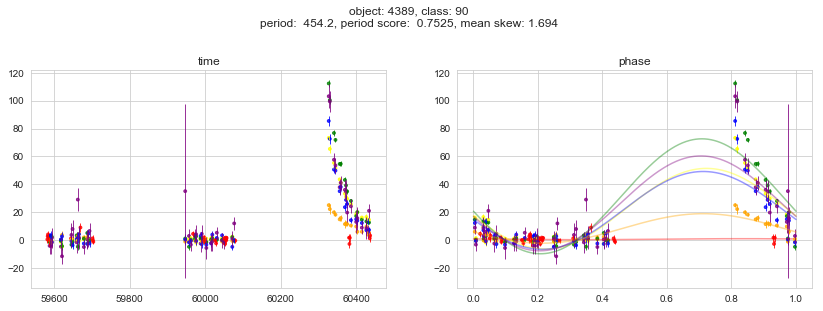

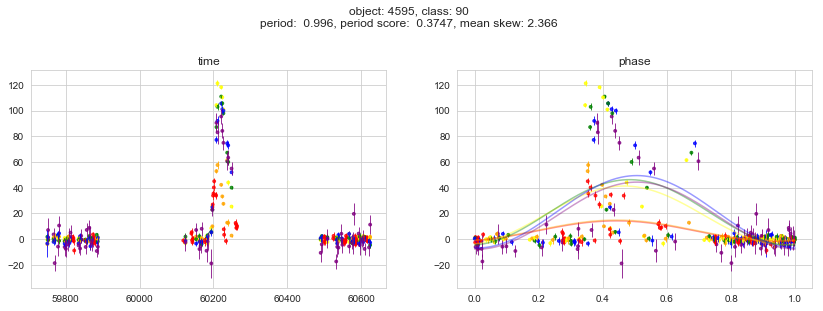

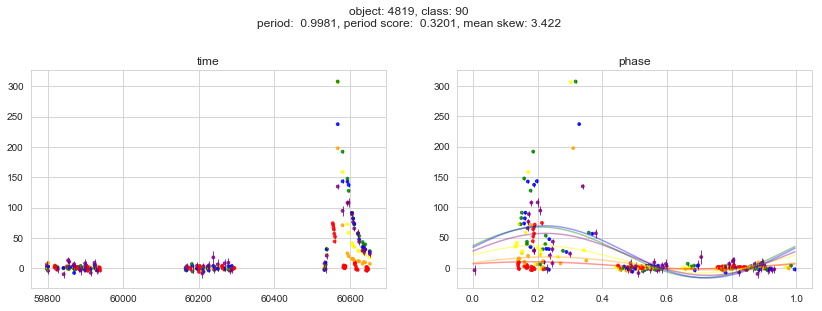

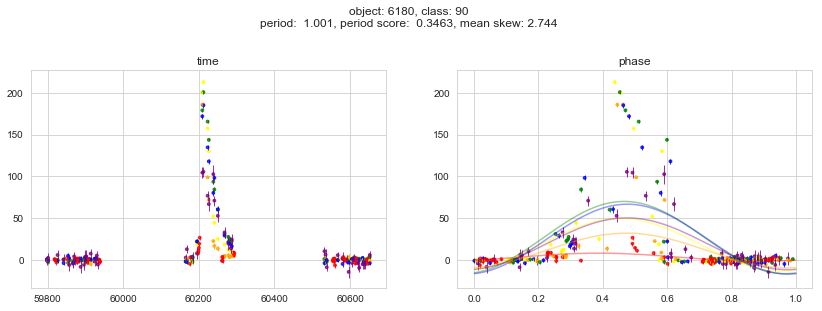

In [17]:
plot_phase_curves(feats, models)

In [18]:
%%capture capt
feats, models = get_class_feats(65)

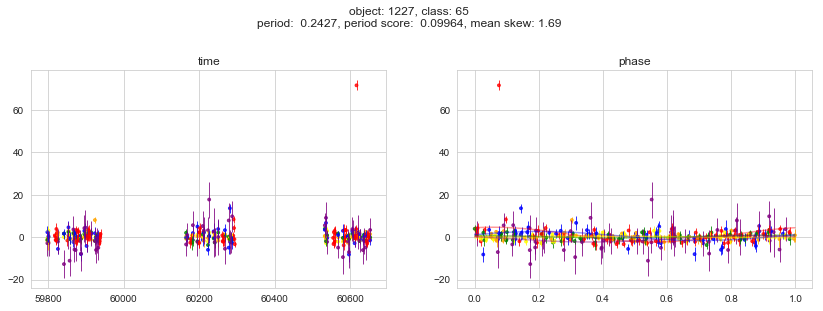

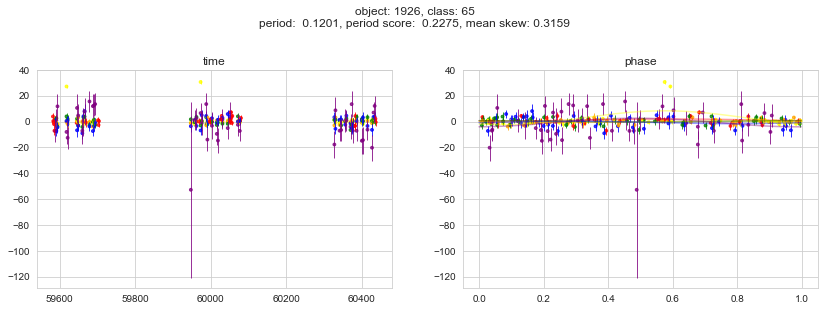

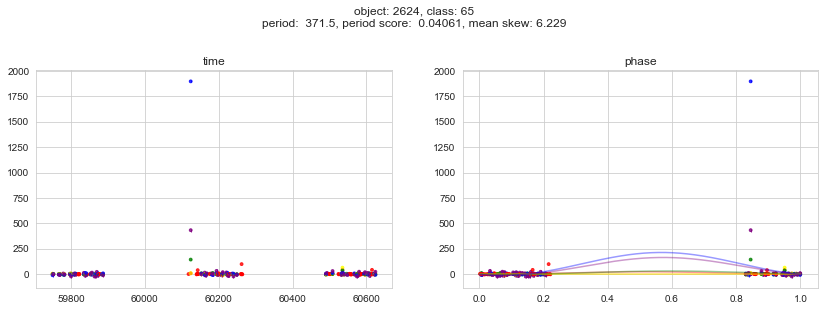

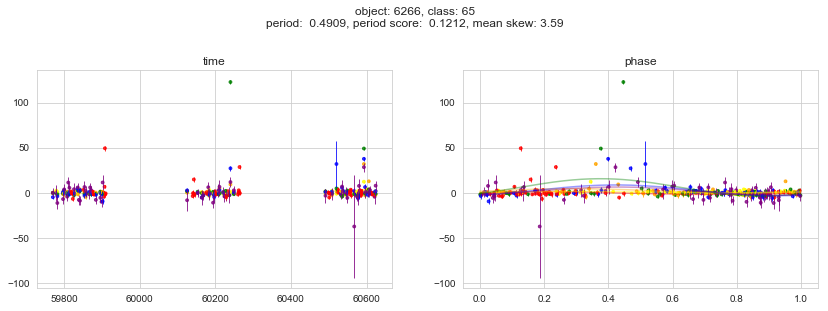

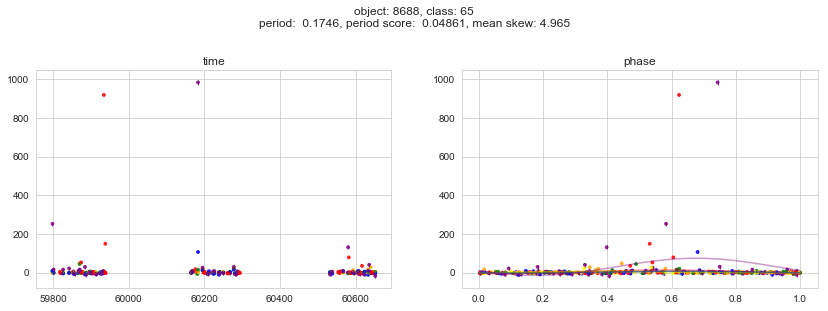

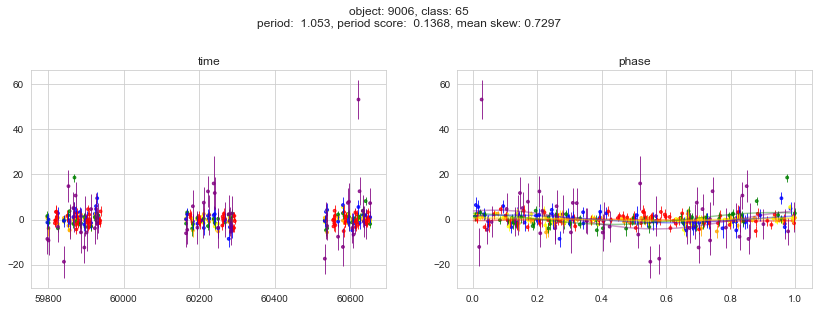

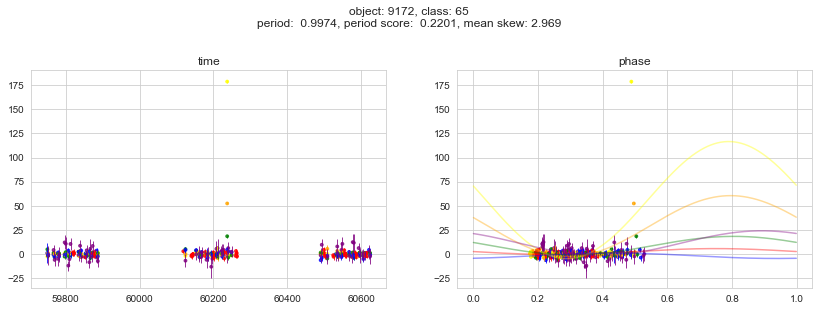

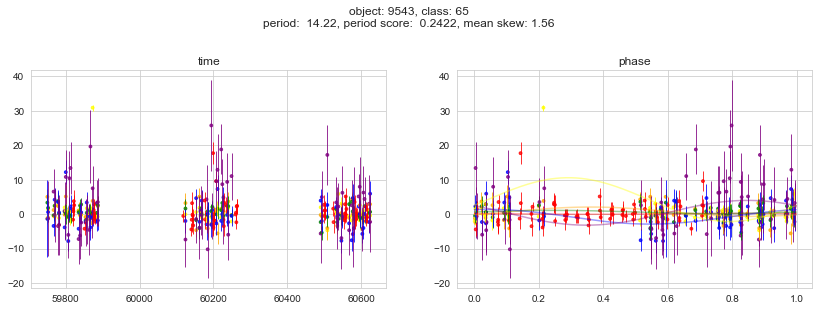

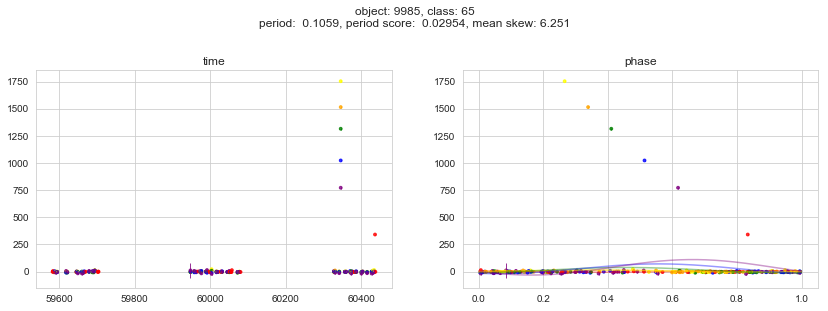

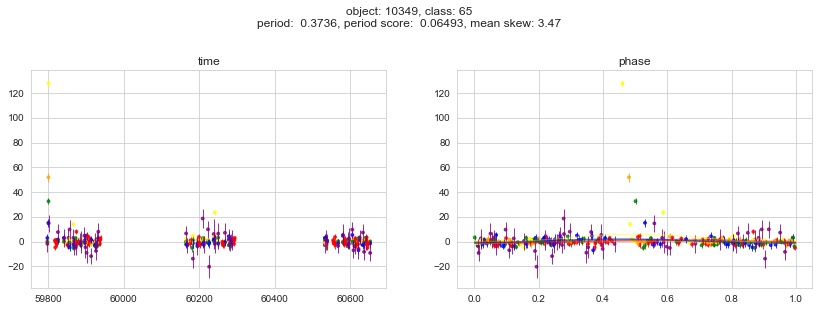

In [19]:
plot_phase_curves(feats, models)

In [20]:
train_series[train_series['object_id'].isin(
    train_metadata[train_metadata['target'] == 65]['object_id'])]['flux'].describe()

count    185894.000000
mean         -3.751268
std         112.271931
min       -1476.489136
25%          -5.358306
50%          -0.438983
75%           2.841231
max       17887.585938
Name: flux, dtype: float64

In [21]:
train_series[train_series['object_id'].isin(
    train_metadata[train_metadata['target'] == 65]['object_id'])]['detected'].mean()

0.08078259653350835

In [22]:
%%capture capt
feats, models = get_class_feats(16)

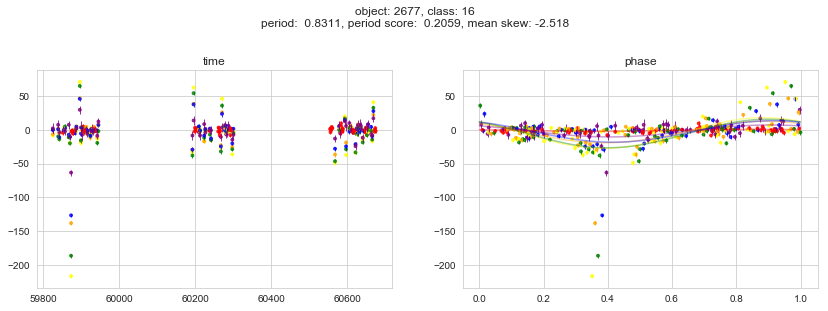

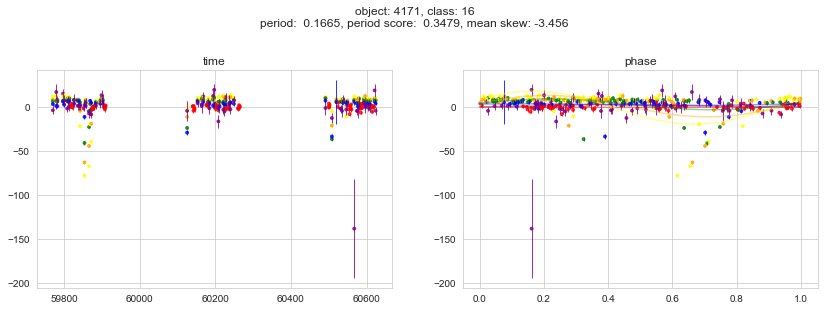

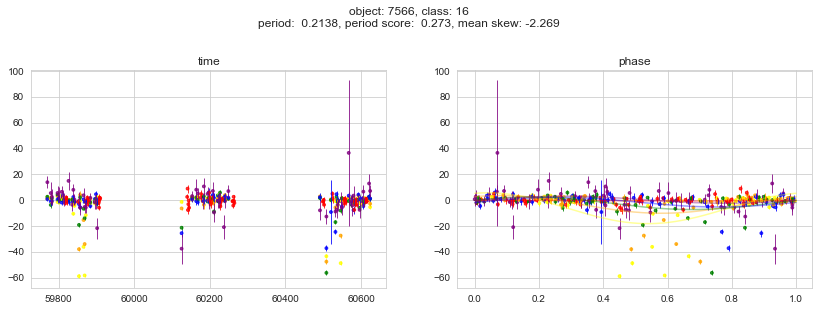

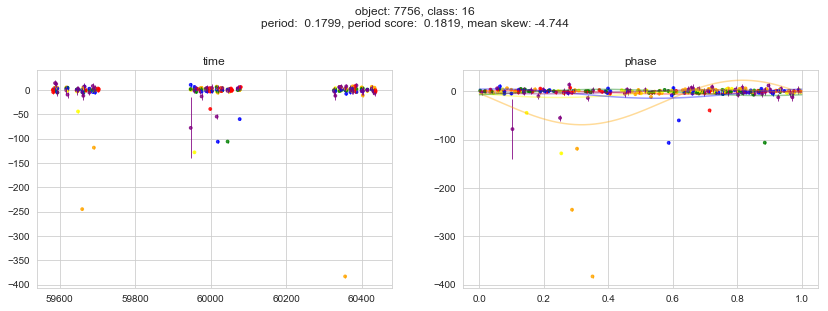

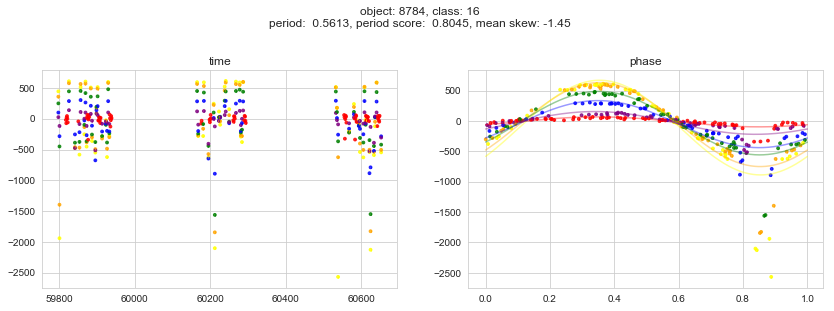

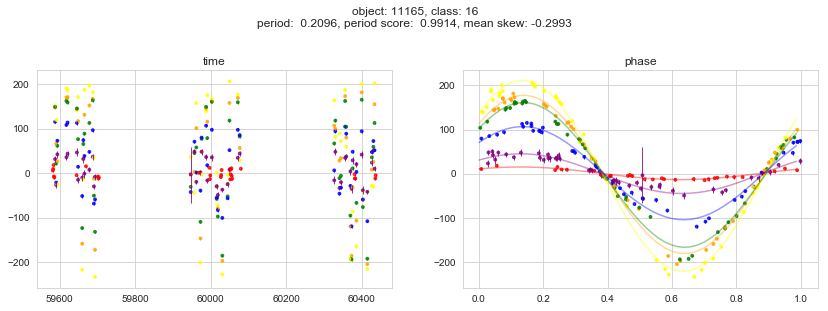

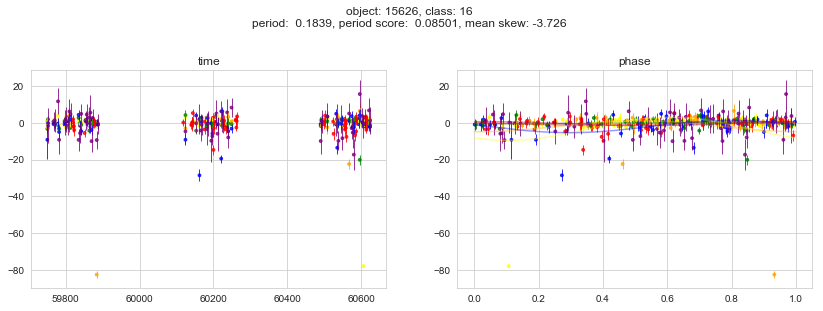

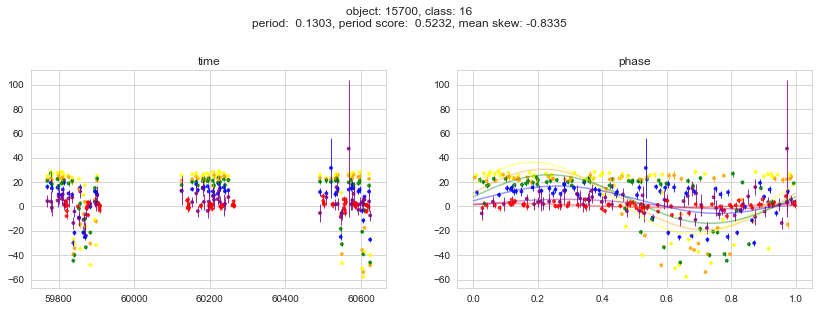

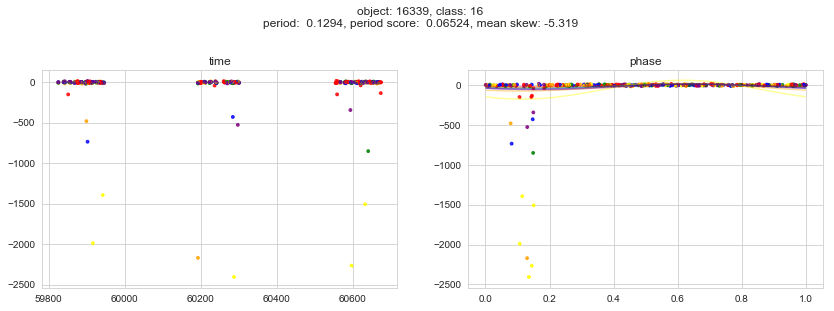

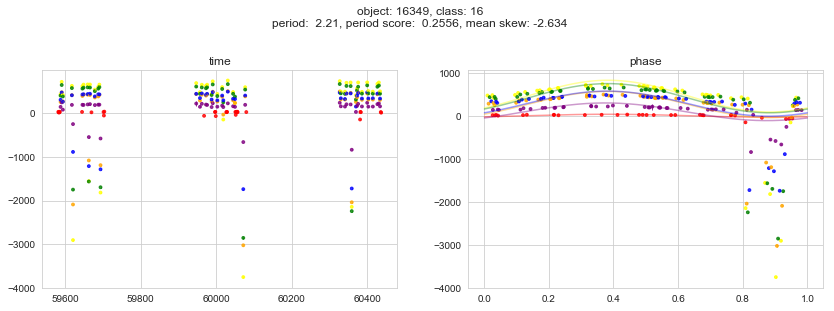

In [23]:
plot_phase_curves(feats, models)

In [24]:
%%capture capt
feats, models = get_class_feats(67)

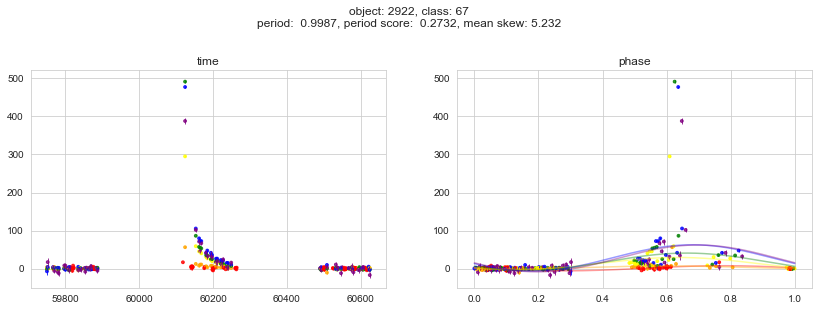

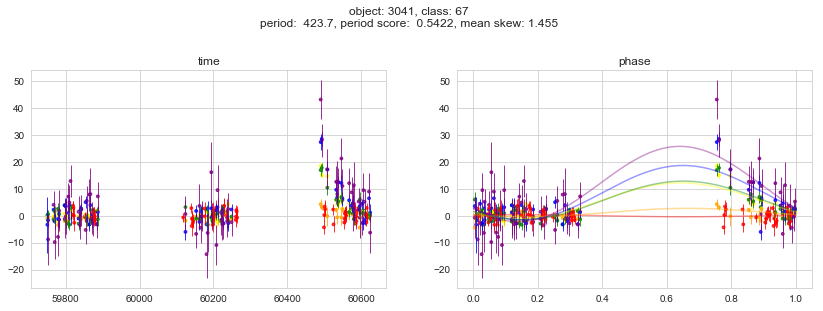

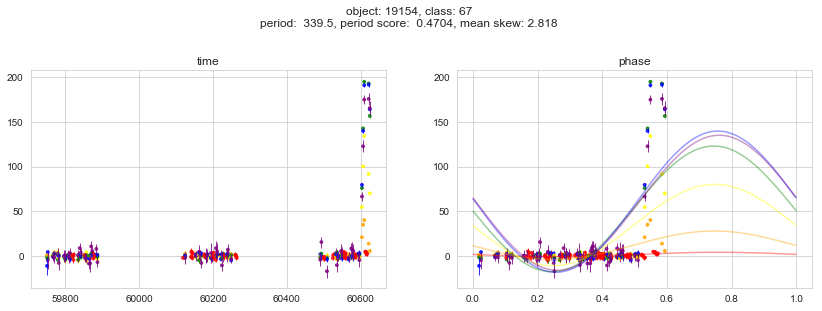

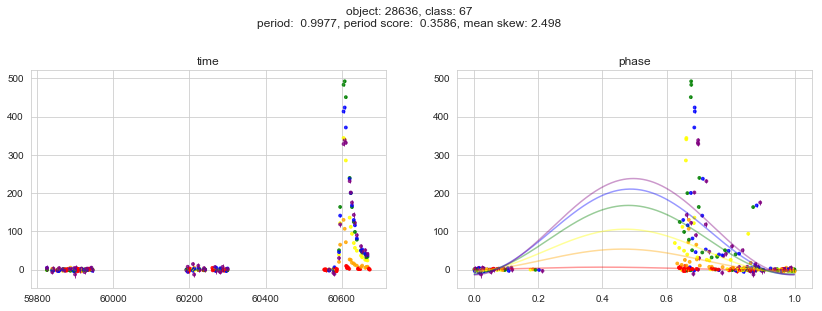

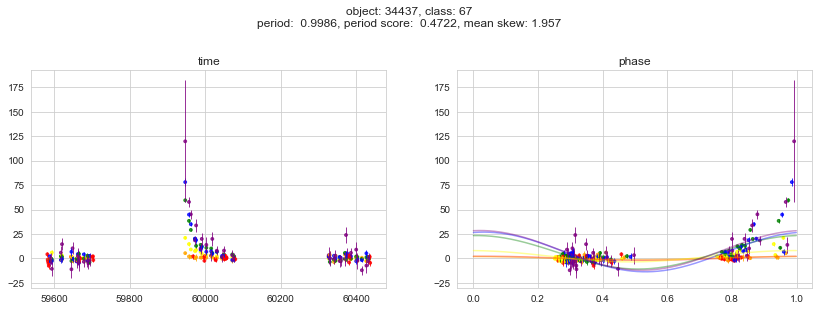

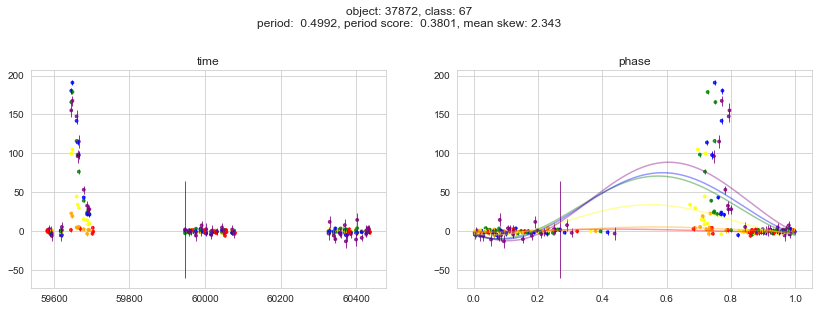

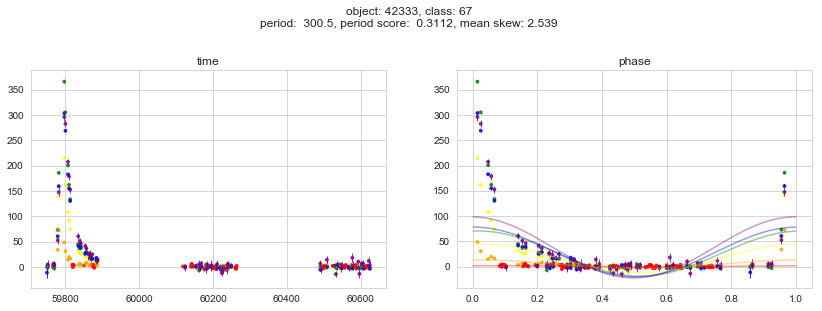

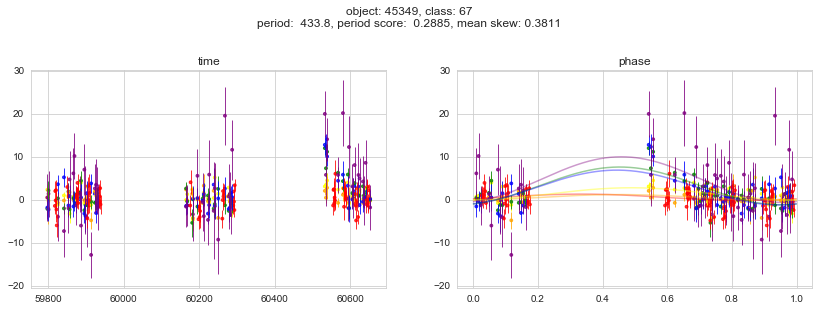

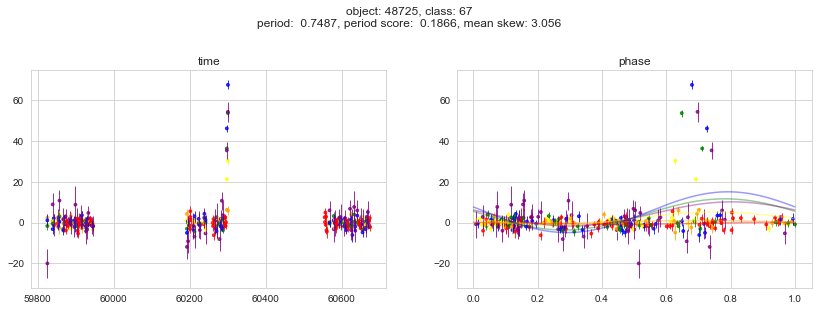

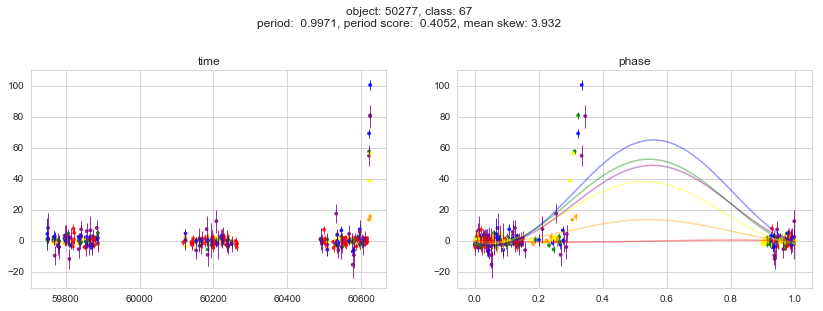

In [25]:
plot_phase_curves(feats, models)

In [26]:
%%capture capt
feats, models = get_class_feats(95)

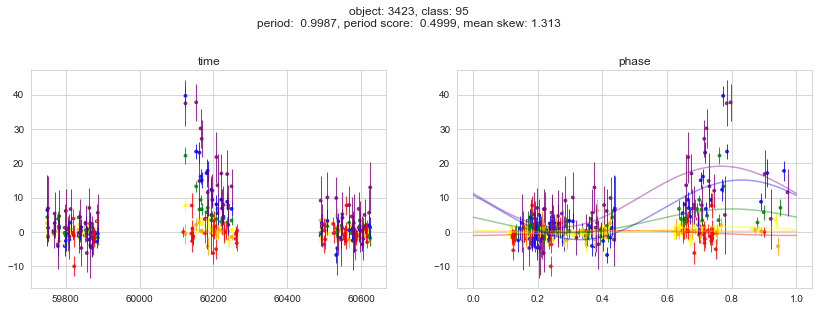

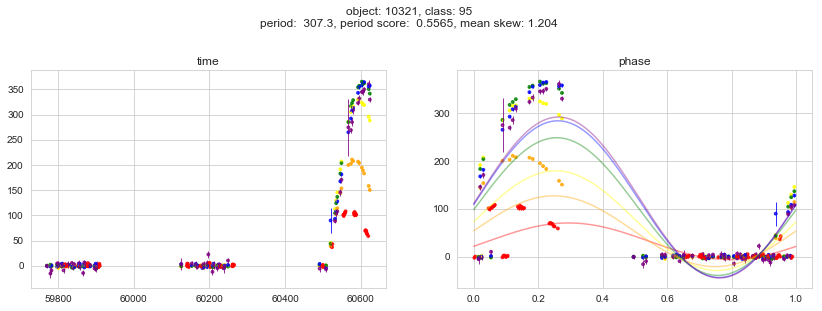

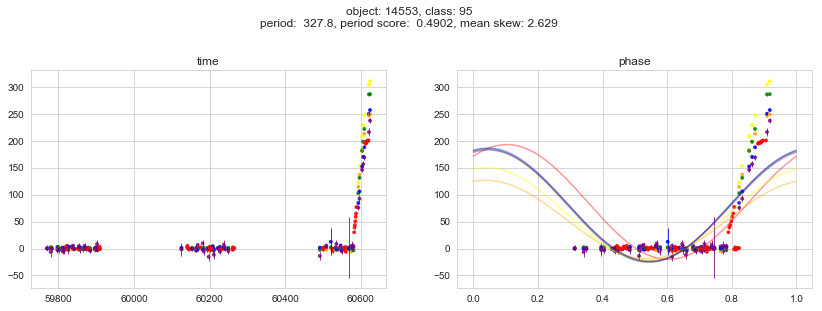

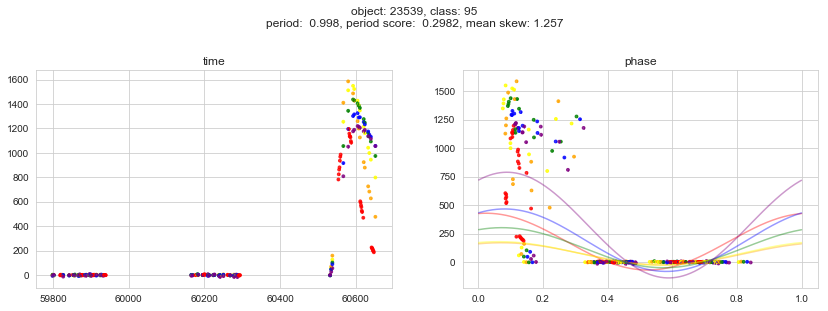

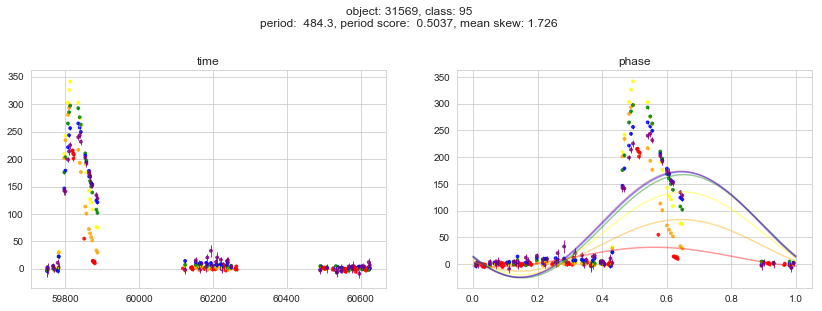

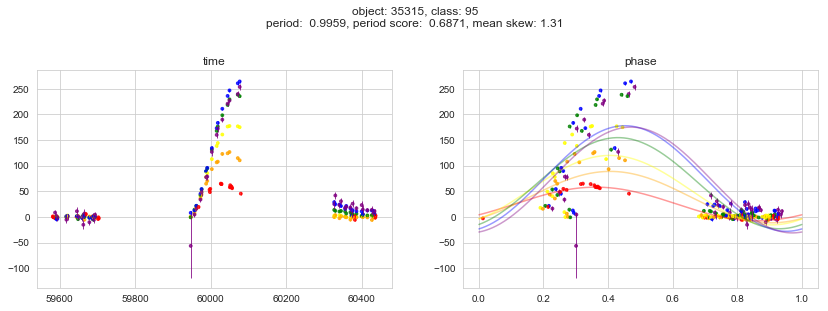

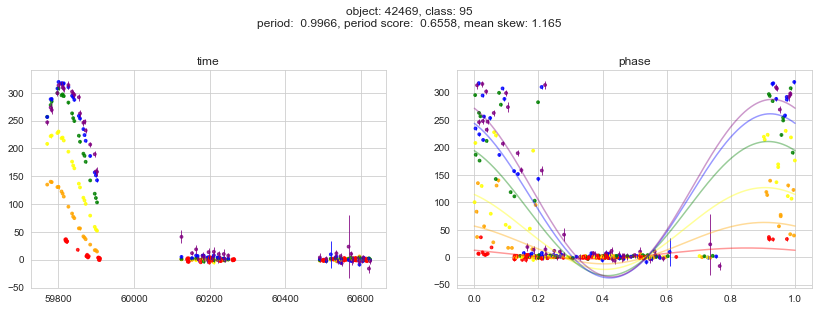

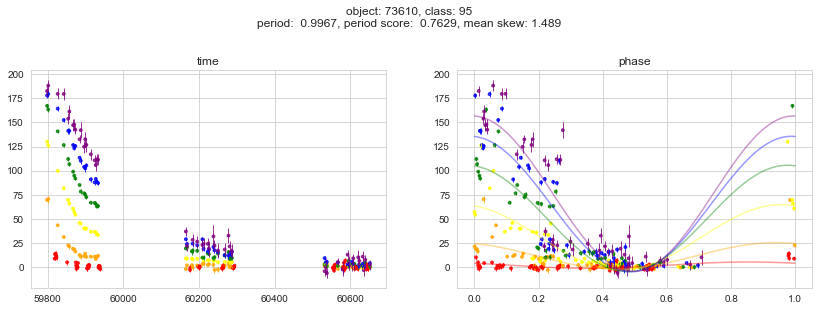

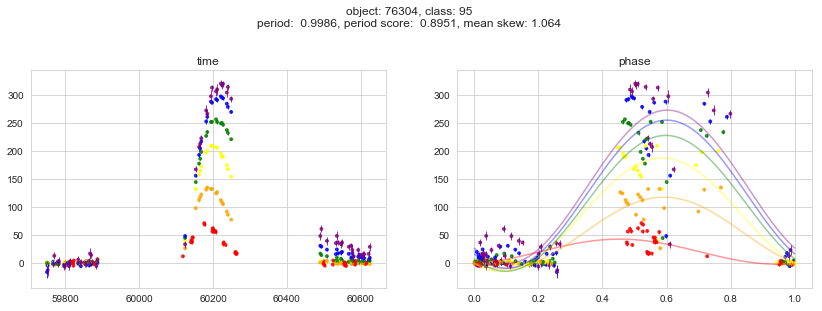

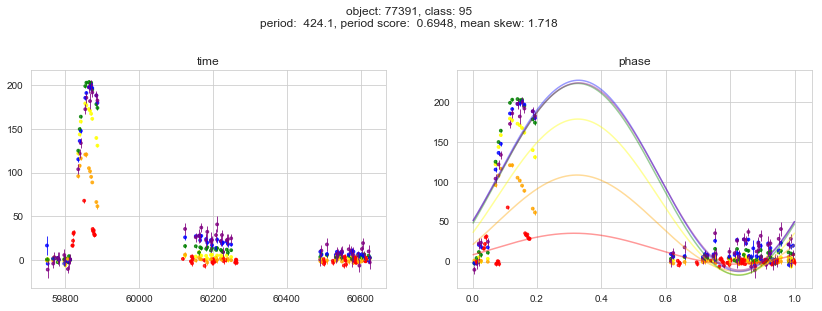

In [27]:
plot_phase_curves(feats, models)

In [28]:
%%capture capt
feats, models = get_class_feats(62)

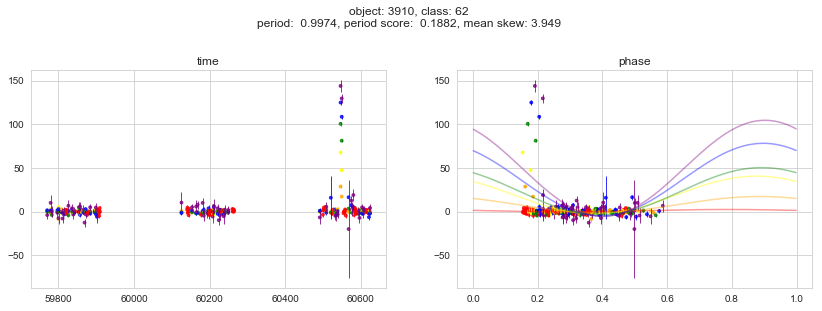

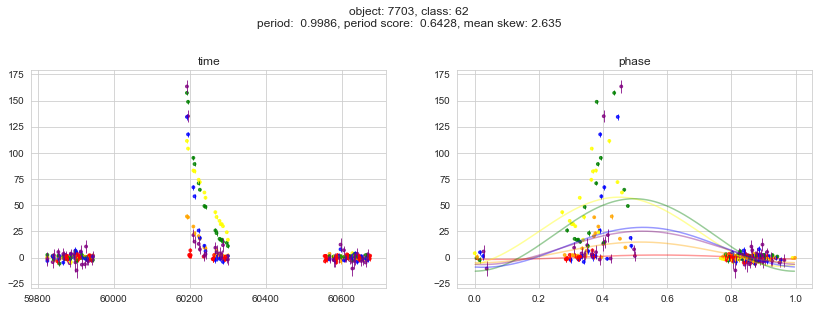

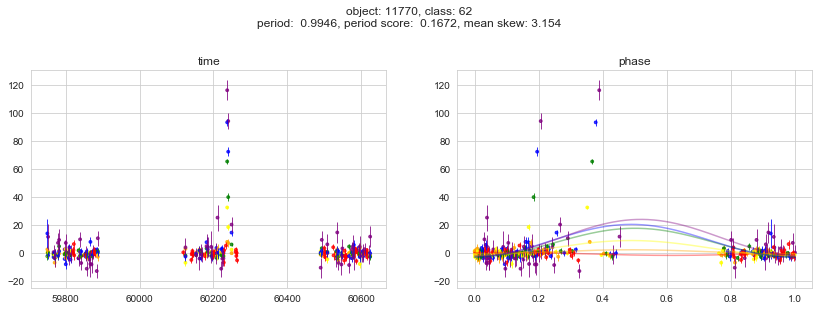

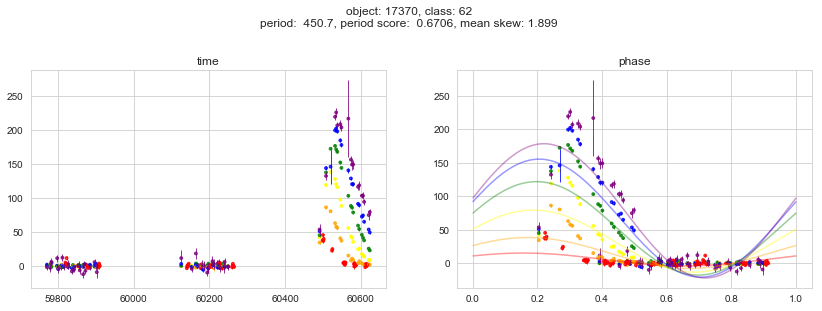

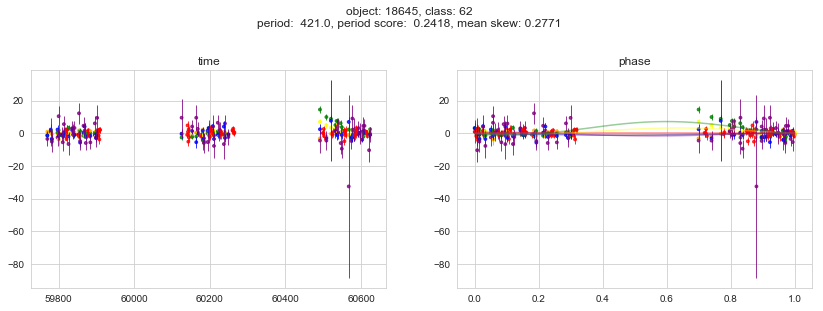

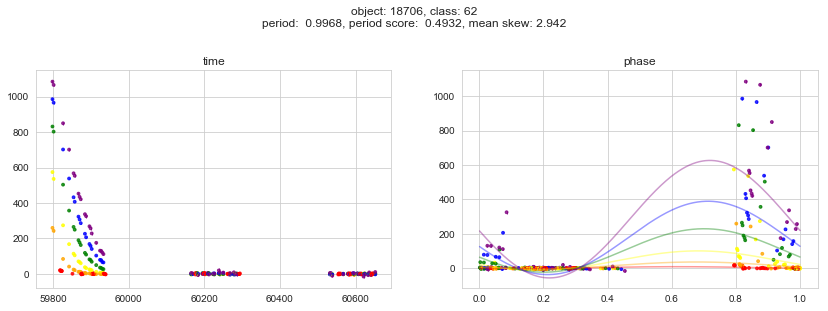

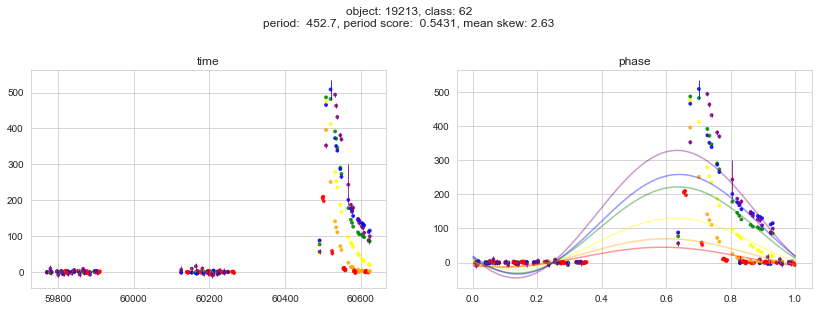

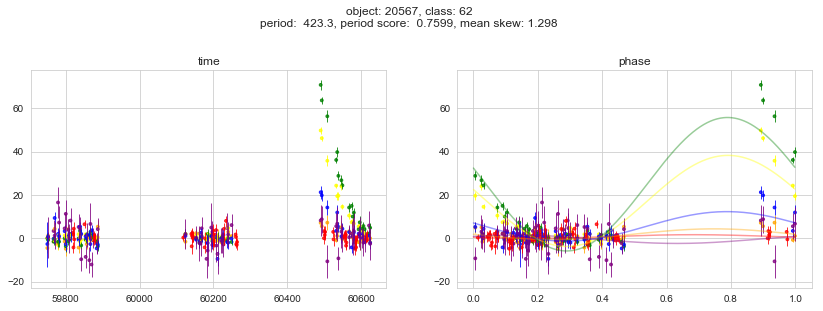

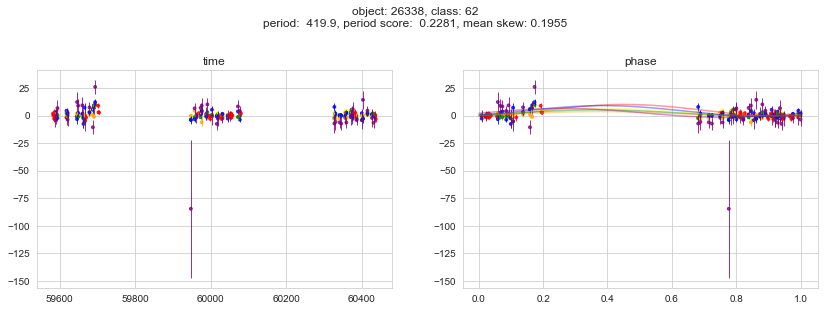

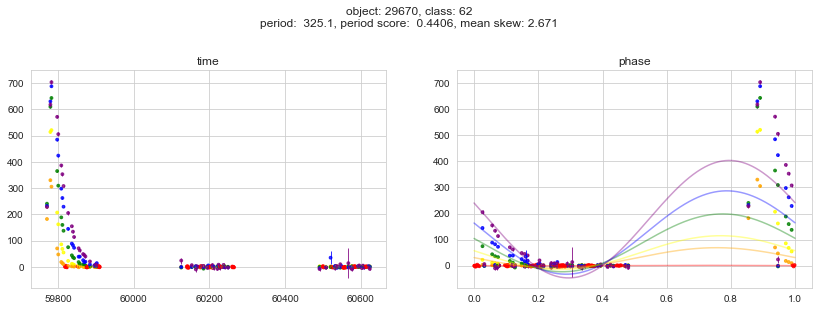

In [29]:
plot_phase_curves(feats, models)

In [30]:
%%capture capt
feats, models = get_class_feats(15)

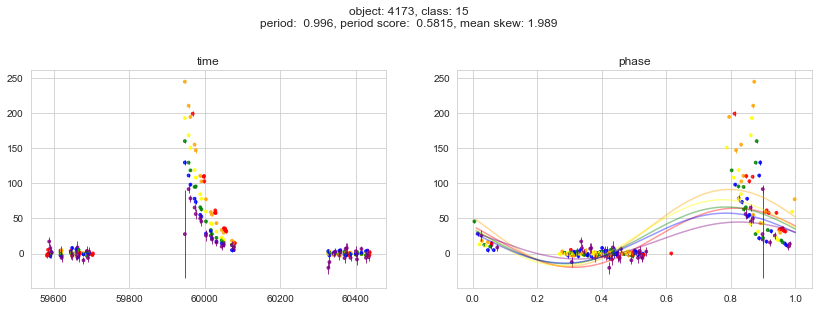

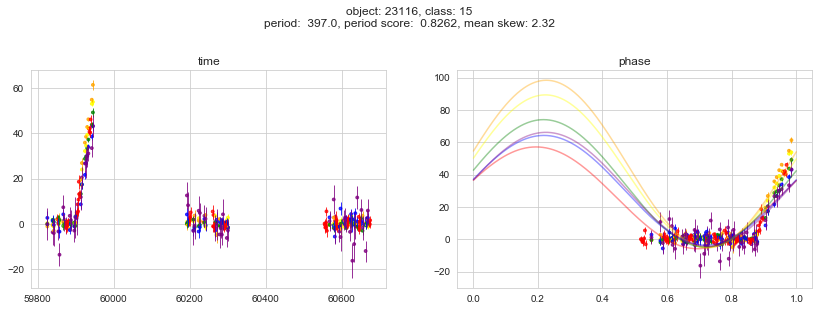

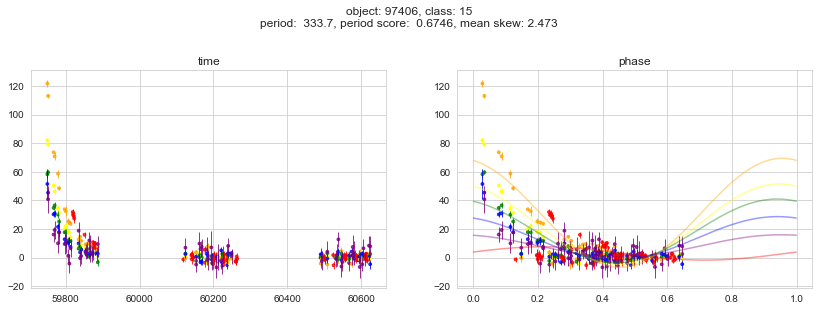

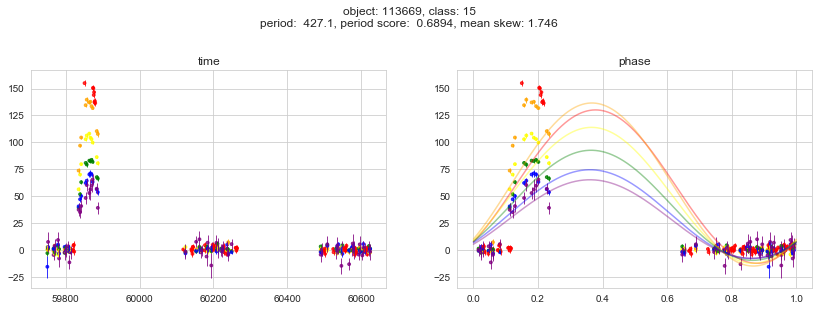

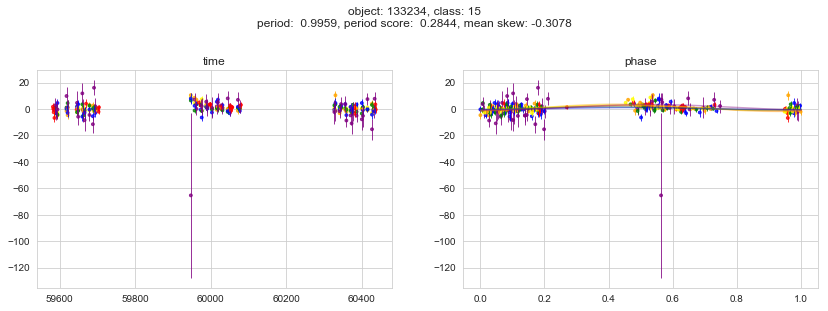

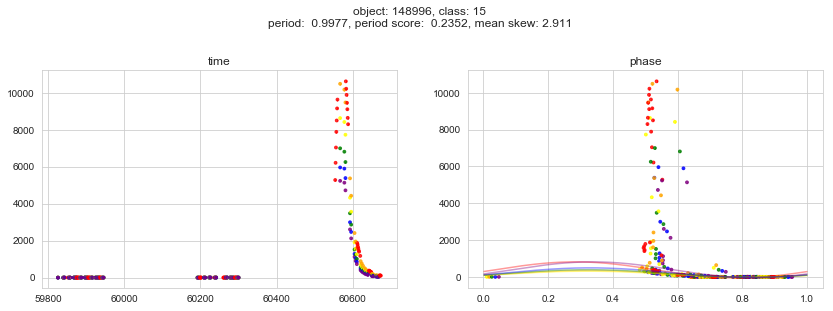

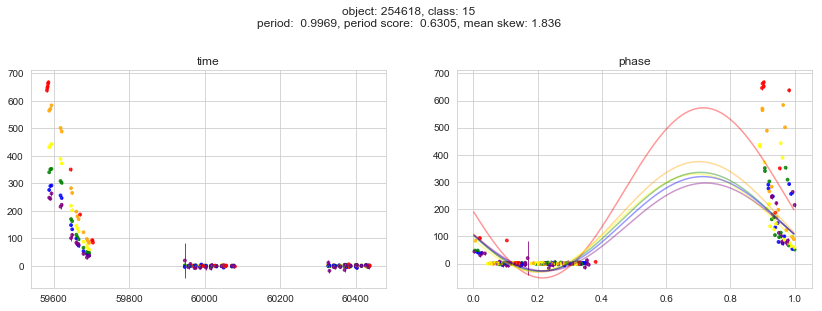

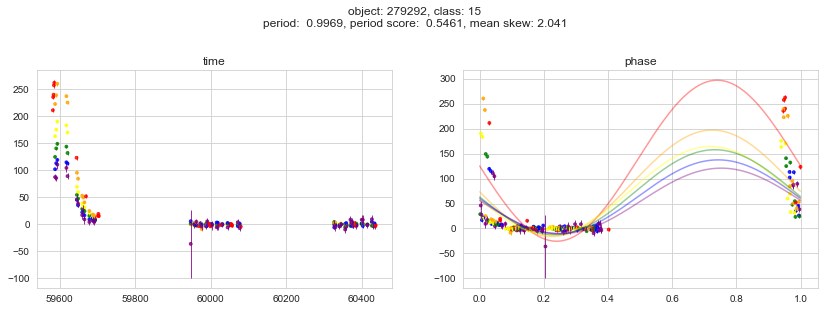

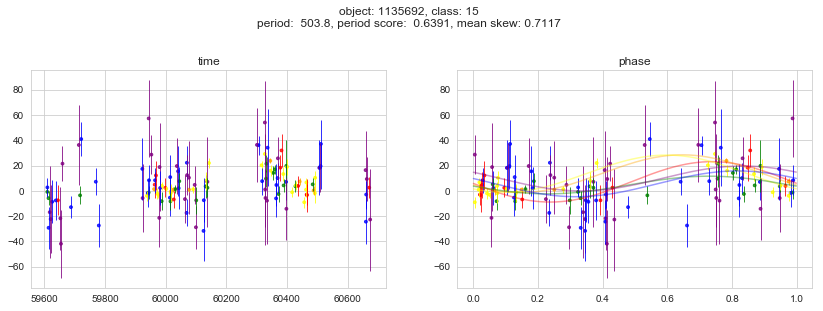

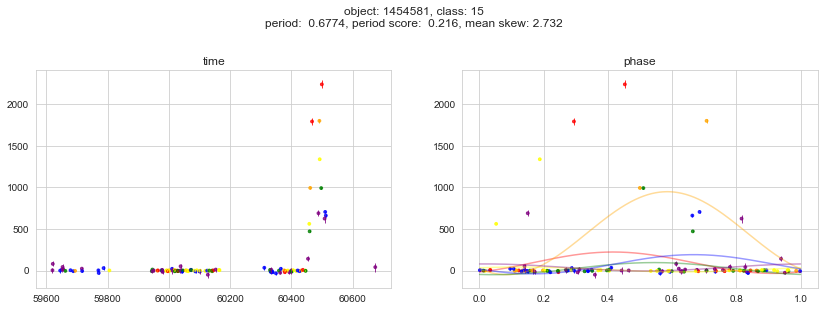

In [31]:
plot_phase_curves(feats, models)

In [32]:
%%capture capt
feats, models = get_class_feats(52)

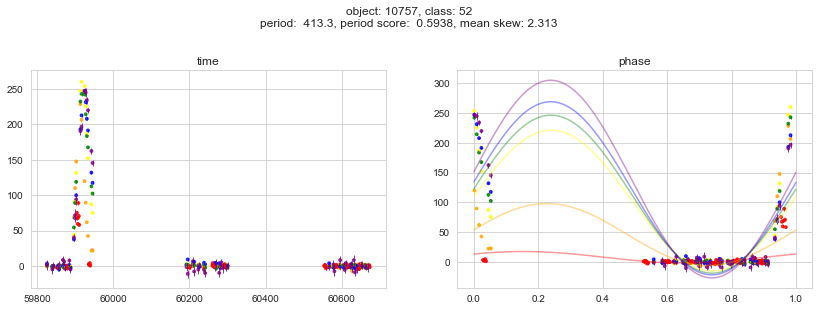

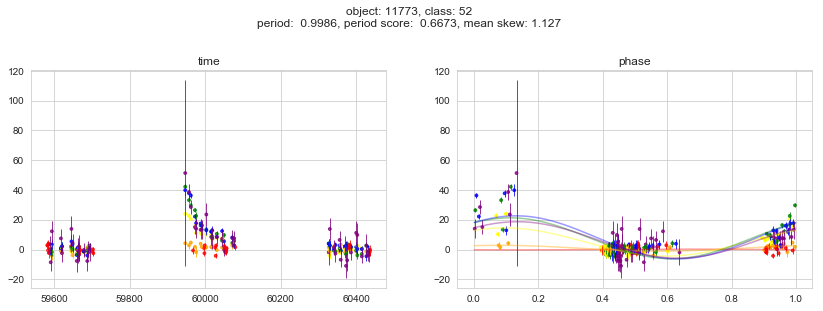

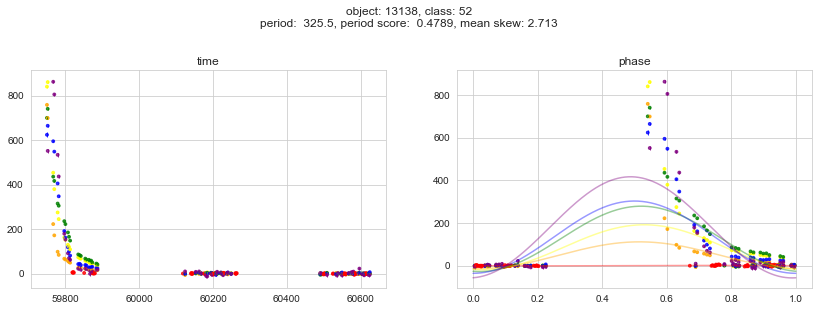

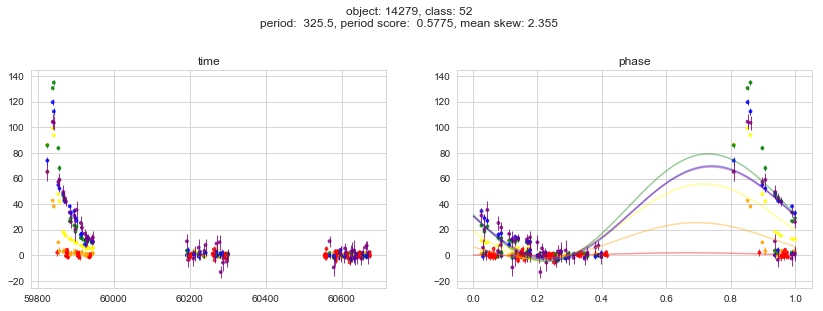

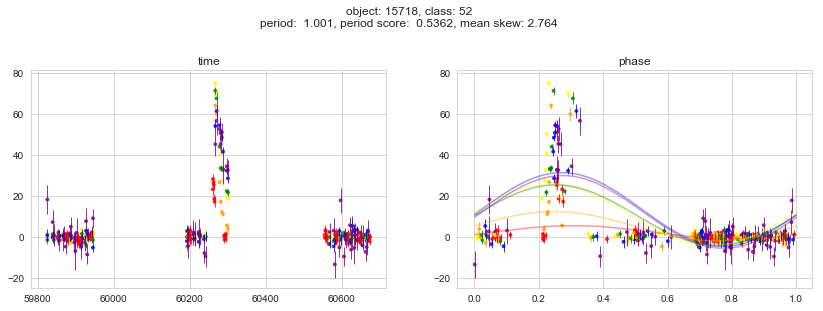

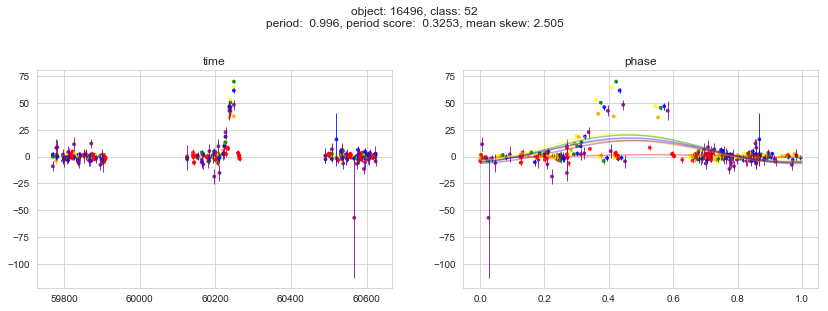

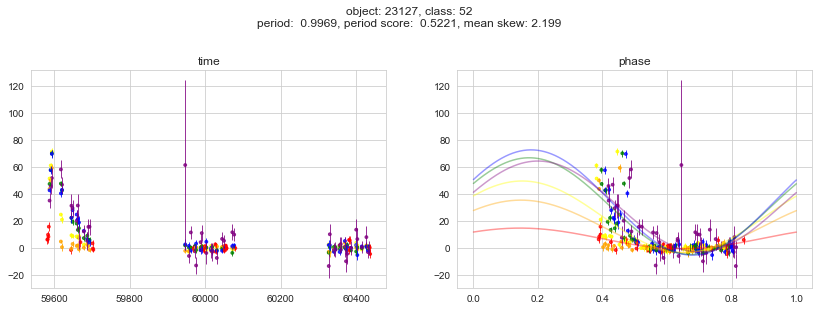

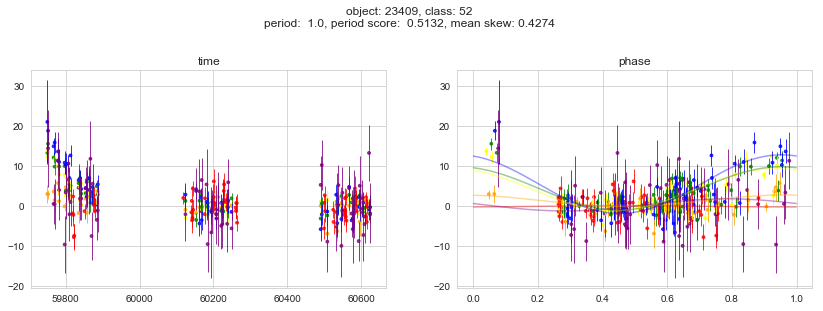

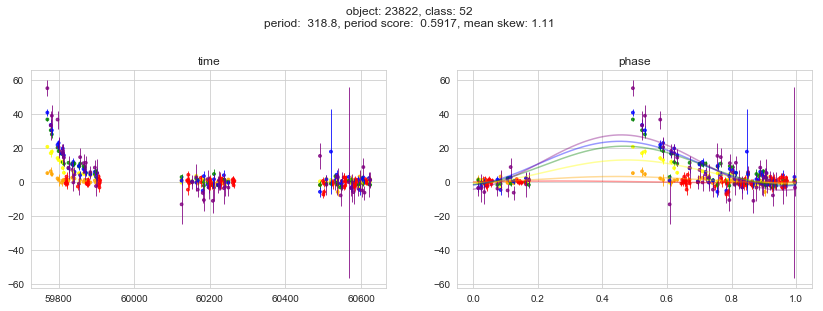

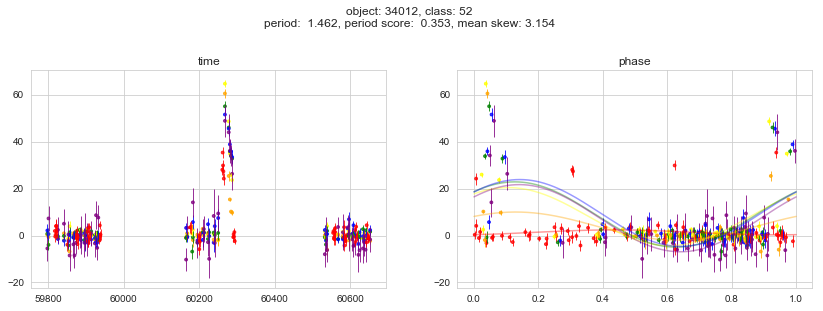

In [33]:
plot_phase_curves(feats, models)

In [34]:
%%capture capt
feats, models = get_class_feats(6)

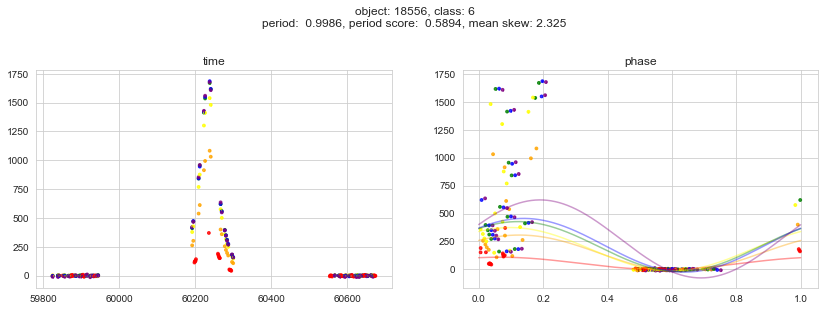

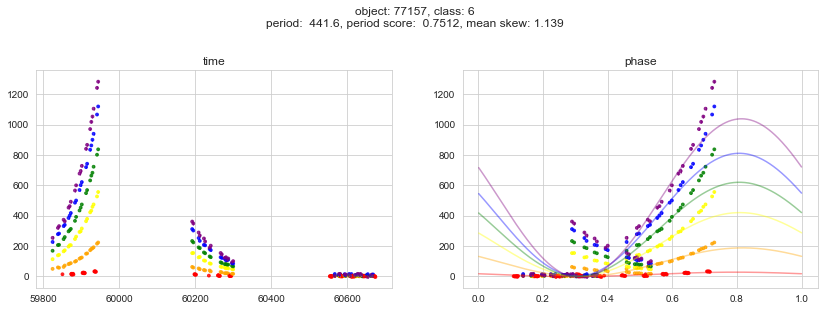

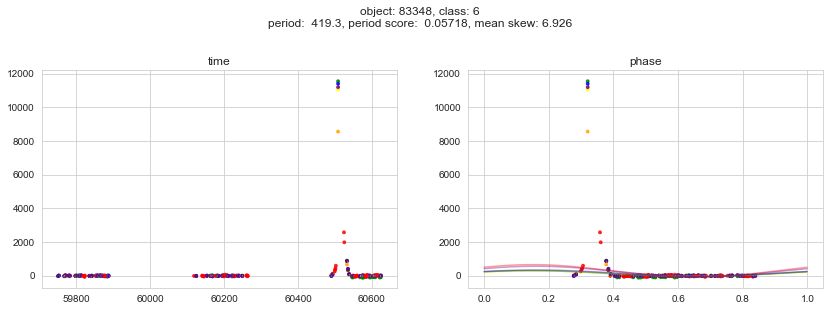

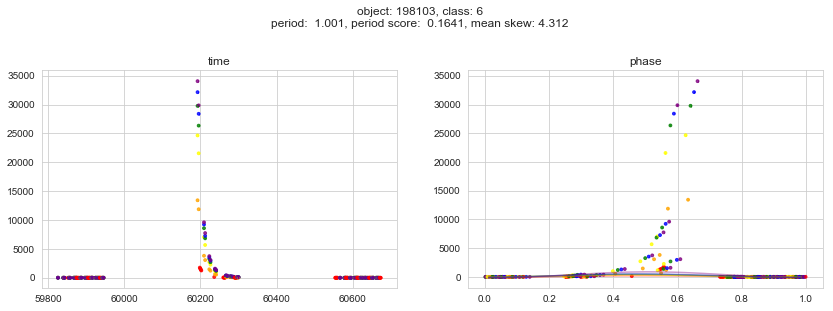

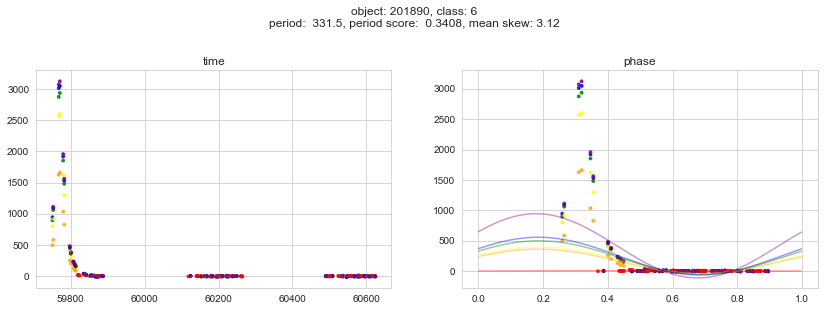

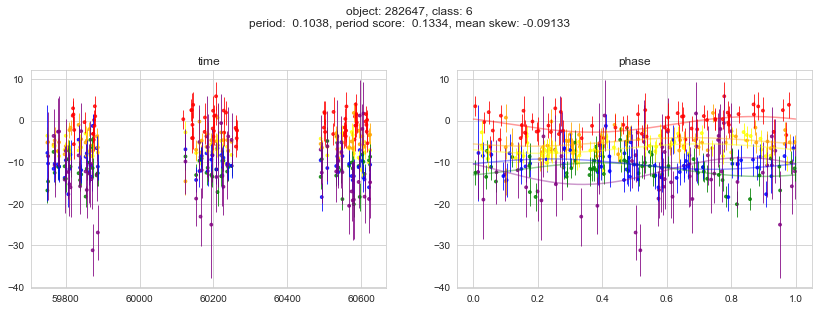

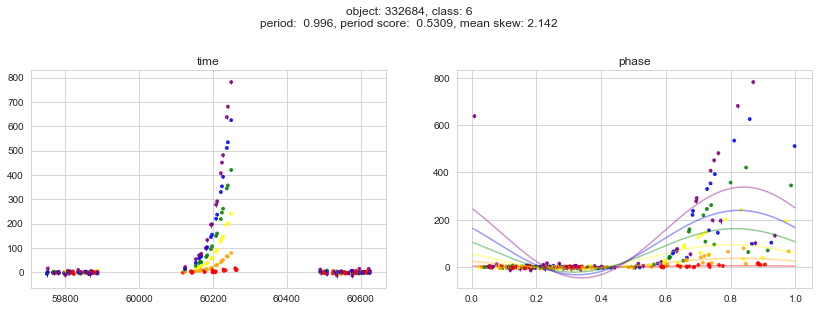

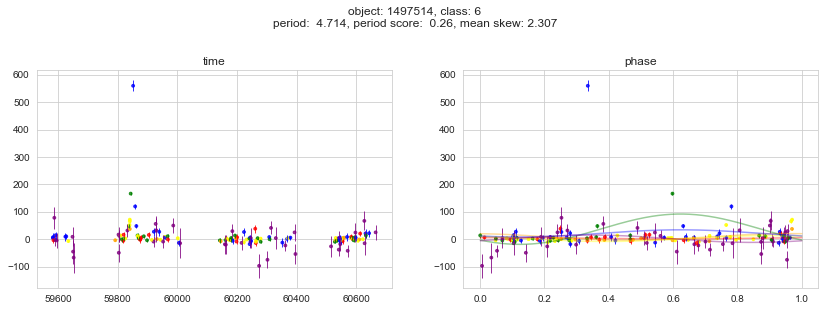

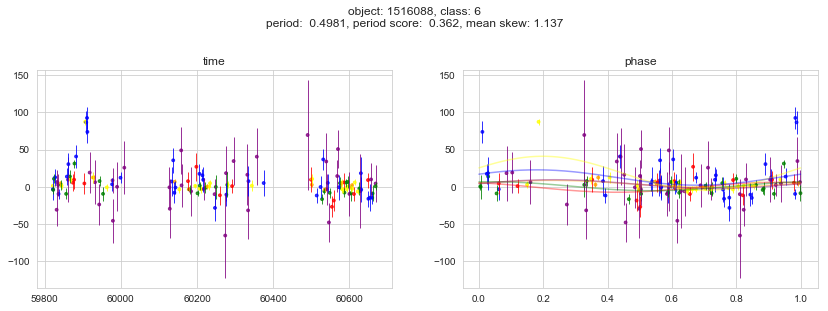

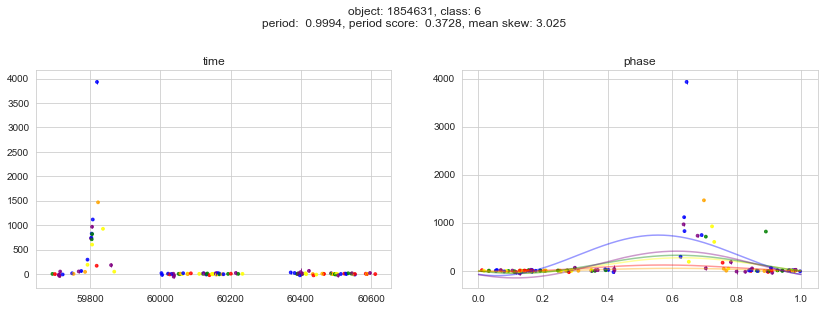

In [35]:
plot_phase_curves(feats, models)

In [36]:
%%capture capt
feats, models = get_class_feats(53)

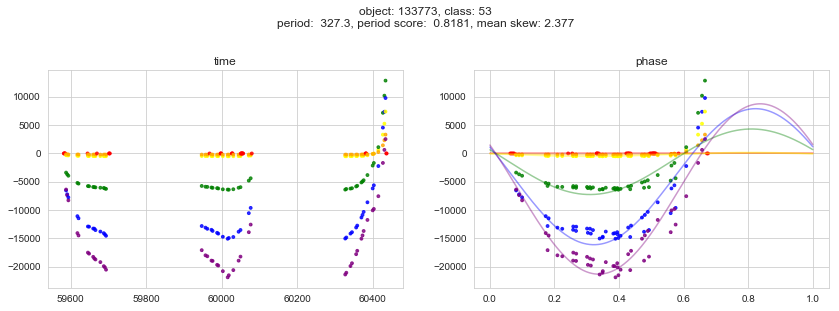

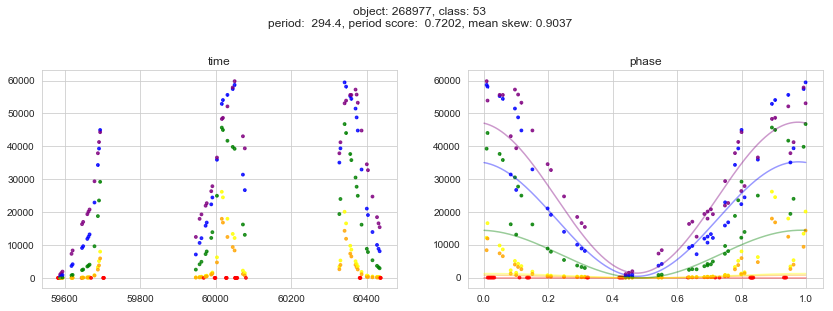

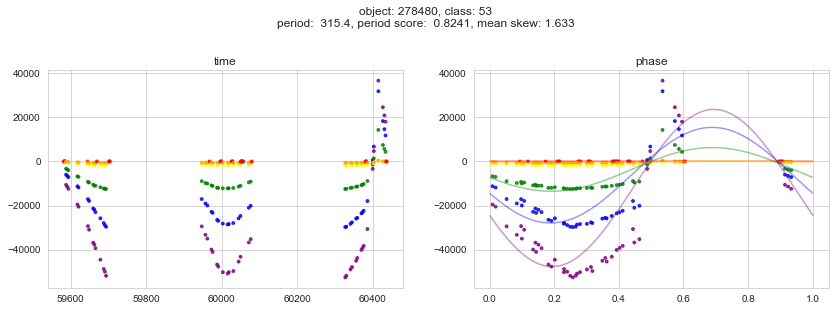

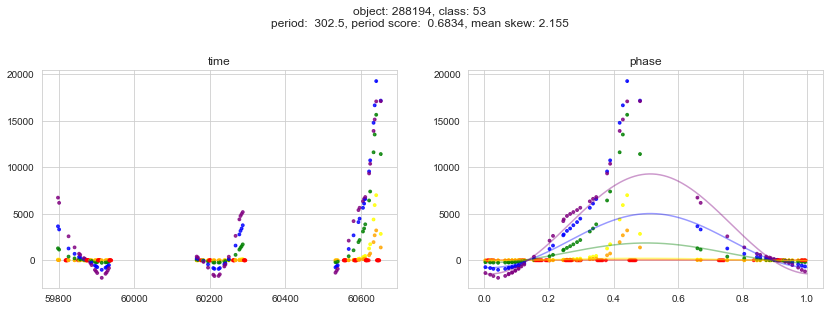

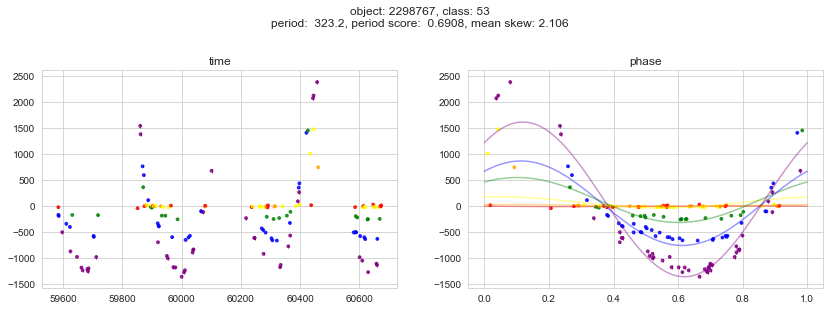

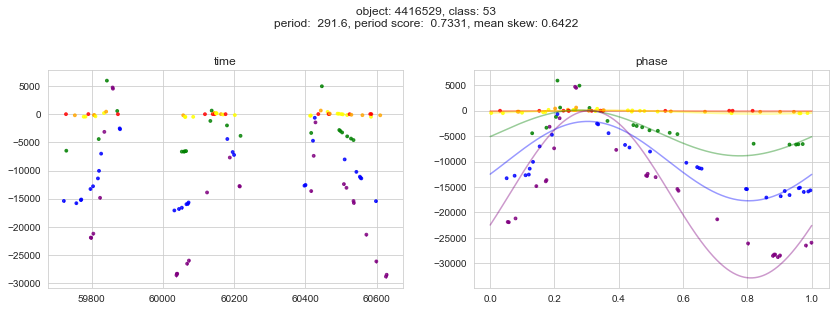

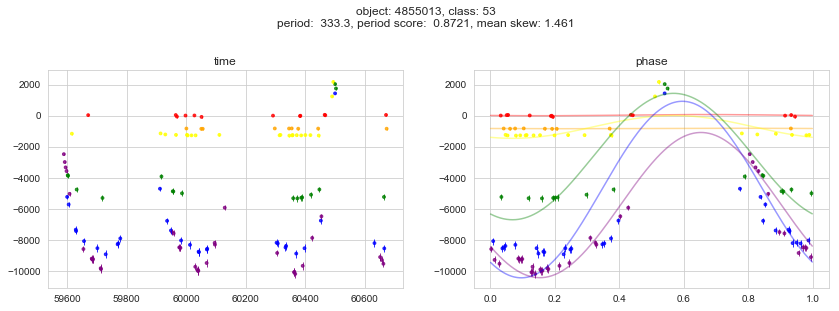

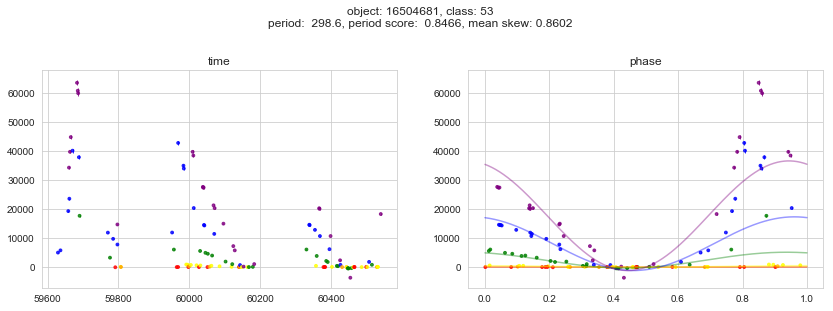

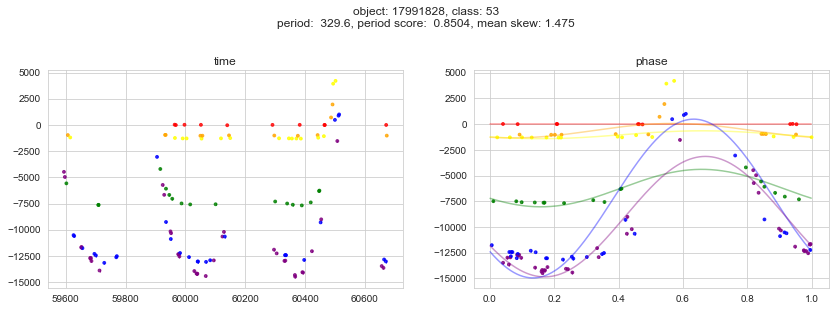

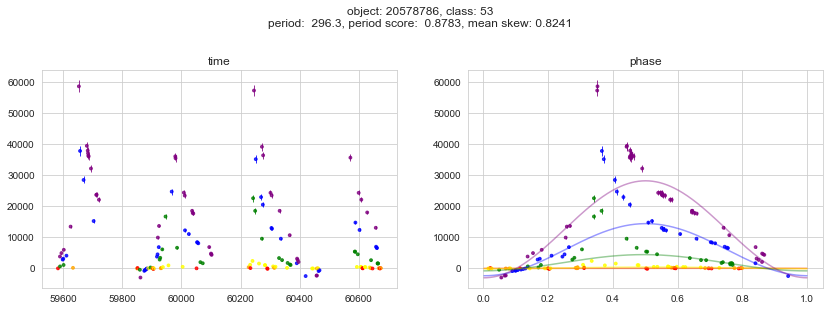

In [37]:
plot_phase_curves(feats, models)